# The SOAM
The methods explored here were distiled and finalized in the 'soam_class' file found in the 'classes_and_methods' folder.

### soam: (noun, english) 
A chain by which a leading horse draws a plough. (mining) A short rope used to pull the tram in a coal-mine. A horse-lead.
#### The Space Object Alias Map (SOAM)
With millions of astronomical objects listed across 14,000+ catalogues it can be quite confusing trying to know exactly what to call that majestic looking spec in the sky. Is that M 31 or is that the Andromeda Galaxy... or is it NGC 224? 

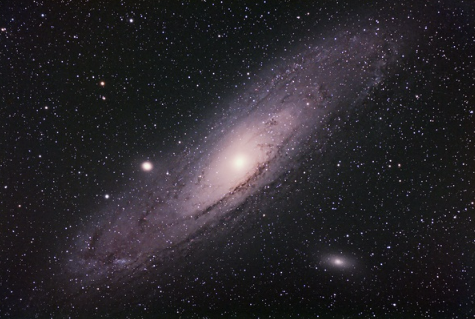 <br>
"M31 180 sec final copyL" -- KevC -- https://www.astrobin.com/304/?q=m31
<br><br>

The correct answer is yes, yes, and yes... and so the confusion continues. There does appear to be avenues available to bring up a list of aliases to a given object name, but they are not yet apparent to me... Searches like SIMBAD will return a list of all known identifiers of an object
http://simbad.cds.unistra.fr/simbad/sim-id?Ident=M+31&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id

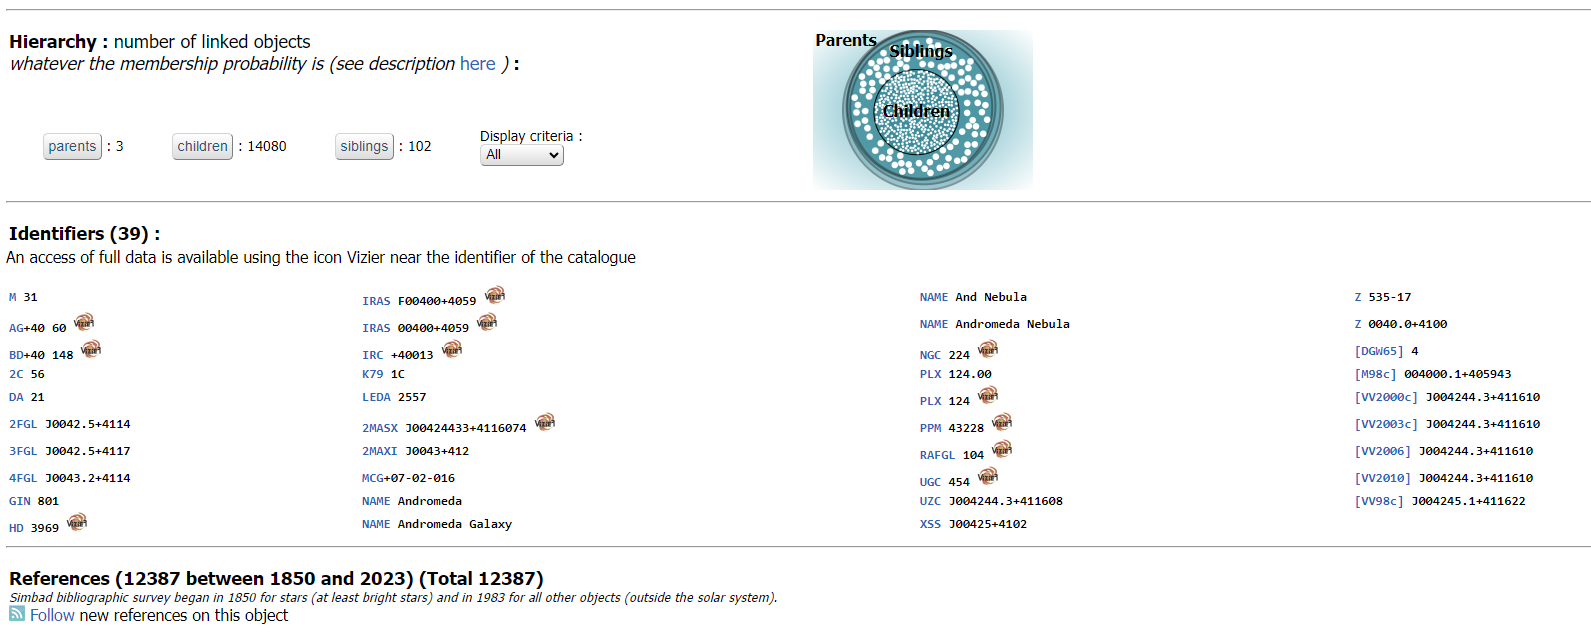

... but I cannot find out how I can access this type of functionality in python... wait a sec [googles "Astropy return all SIMBAD identifiers of an object like M 31"]

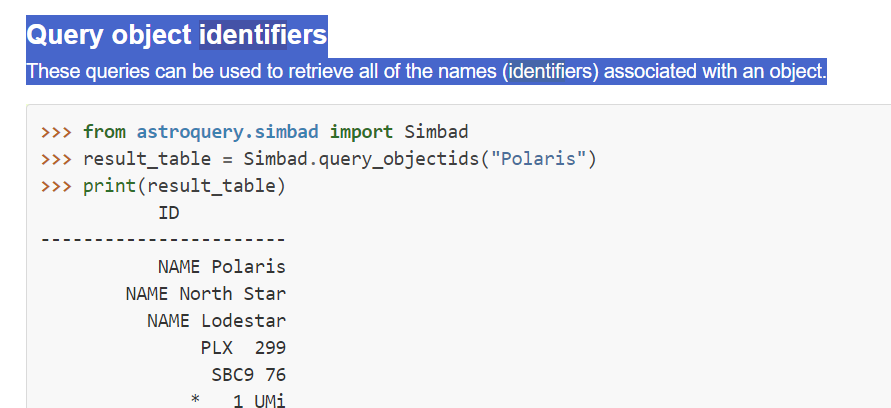

https://astroquery.readthedocs.io/en/latest/simbad/simbad.html#:~:text=Query%20object%20identifiers,with%20an%20object.

In [1]:
import pandas as pd

In [2]:
#TESTING
from astroquery.simbad import Simbad
result_table = Simbad.query_objectids("M31")
#[print(x[0]) for x in result_table] # works good!
print("--Done--")

--Done--


... welp, that works! ... but note the limitations:

In [3]:
#TESTING -- LIMITATION NOTE: Simbad.query_objectids does not handle international language well

#ENGLISH SEARCH for the "Cigar Galaxy"
result_table = Simbad.query_objectids("Cigar Galaxy")
if(result_table):
    print("RESULT")
else:
    print("NO RESULTS")
print(" -- Done -- ")

#GERMAN SEARCH for the Zigarren Galaxie
result_table = Simbad.query_objectids("Zigarren Galaxie")
if(result_table):
    print("RESULT")
else:
    print("NO RESULTS")
print(" -- Done -- ")

RESULT
 -- Done -- 
NO RESULTS
 -- Done -- 


In [4]:
#TESTING -- LIMITATION NOTE: Simbad.query_objectids does not handle solar objects
result_table = Simbad.query_objectids("Moon")
if(result_table):
    [print(x[0]) for x in result_table]
else:
    print("NO RESULTS")
print(" -- Done -- ")

NO RESULTS
 -- Done -- 


### What Objects Can be Found in the AstroPy SIMBAD Search?
The SIMBAD data base presently contains information for about 13,000,000 astronomical objects (stars, galaxies, planetary nebulae, clusters, novae and supernovae, etc.).

### What Objects are Excluded in the AstroPy SIMBAD Search?
The only astronomical objects specifically excluded from SIMBAD are **Solar System bodies** (planets, satellites, asteroids, comets)

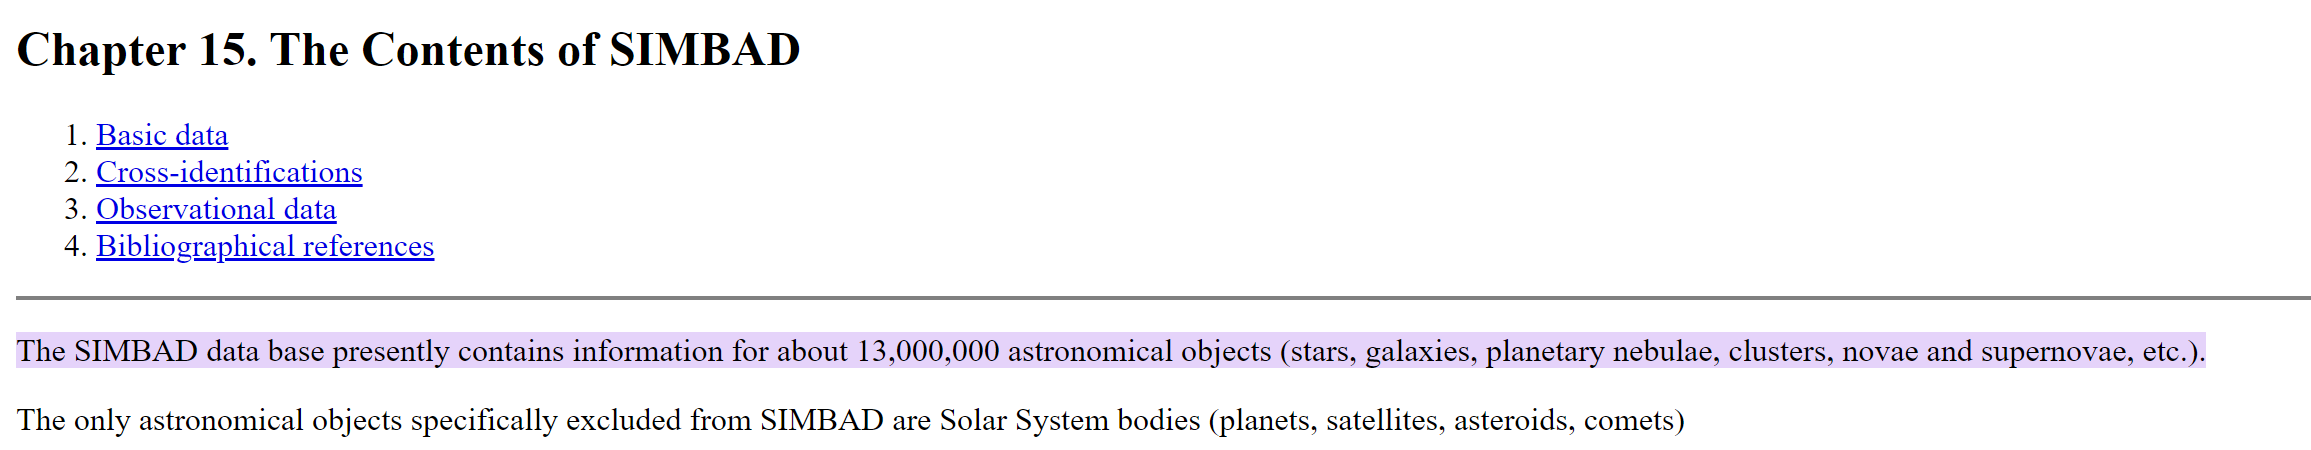

http://simbad.u-strasbg.fr/Pages/guide/ch15.htx#:~:text=The%20SIMBAD%20data%20base%20presently,and%20supernovae%2C%20etc.).



#### Object Selection for the SOAM
It does not seem like a good idea to include all 13 million SIMBAD objects in the SOAM. Nor should we not include solar system objects either. The objects listed in the SOAM must cover the objects available to the amatuer astrophotographer. Today this really means just the objects we can see and photograph from earth... but if the SOAM continues on as a resource it must accomadate growth for reasons such as:
* Increased alternative naming conventions and other changes to the naming of astronomical objects (language is dynamic, never static...)
* The increased access to space telescopes could lead to new objects making appearances on AstroBin. Those names should also be added.
* Some objects (like comets) are observed once in a life time... even once in history... those names should be added to the SOAM as those types of objects get uploaded into AstroBin. 

### Goal of the SOAM
Provide a "light weight" data structure that has fast searchability / reference to a comprehensive list of an objects aliase names and ids.


A few next steps to consider:
* This astropy query will not play well with a live environment where speed is of the essence, we will need a pre-organized view of these aliases that do not rely on an astropy query (this will be our SOAM).
* Another issue will be the fact that we have international language that AstroPy does not deal with (example being that a German search for the "Zigarren Galaxie" does not return anything from SIMBAD) 
* But first we need to find our focus (we cannot pull all space objects into the SOAM... that would be crazy)... how can we grab the objects that AstroBin users use?

In [5]:
print("---START CLEANING---")
import pandas as pd #For data frame management
# Data Load (provided by Salvatore from AstroBin site)
df = pd.read_csv("data/astrobin_titles_to_subject_types.csv") #the main starting data frame

#HOUSE KEEPING -- Casting 'subject_type' and 'solar_system_main_subject' as categories
cats = ['subject_type','solar_system_main_subject']
df[cats] = df[cats].astype('category')

#CLEANING -- remove all null rows
before = df.shape[0] #row count before
df = df.dropna(how='all') #droping only the rows with 'na' across ALL columns
after = df.shape[0] #row count after

print(str(before-after)+" Null Rows Removed")

#CLEANING -- remove all null rows
before = df.shape[0] #row count before
df = df.dropna(subset=['title']) #droping only the rows with 'na' ONLY in title column
df = df[~df['title'].str.isspace()] #droping only the rows with '  ' (white space) as title
df = df[df['title']!=''] #droping only the rows with '' (dead space) as title
after = df.shape[0] #row count after

print(str(before-after)+" Null Title Rows Removed")

#CLEANING the unwanted words out of the string column (use all lower case)
unwanted_words = ['the', 'and', "in", "of"] #there are other words like " on " 
# ...but those may be more indicative of the category they are found in... 
#... (like " on " being a very common word in GEAR)...
#... (or like " at " being a very common word in STAR_TRAILS)

#CLEANING some other language words out
other_unwanted_words = [
    'du', 'la', 'de', 'le'
]
#If you want to add this extra cleaning step for other languages, leave this line
unwanted_words = unwanted_words+other_unwanted_words

# Regular expression pattern to match any unwanted word
pattern = r'\b(?:{})\b'.format('|'.join(unwanted_words))
# Remove unwanted words using the pattern with str.replace() and put cleaned strings their own col
df['cleaned_title'] = df['title'].str.lower().replace(pattern, '', regex=True)
print("---CLEANING DONE---")
title_df = df.copy()
print("---df COPIED INTO title_df---")

---START CLEANING---


FileNotFoundError: [Errno 2] No such file or directory: 'data/astrobin_titles_to_subject_types.csv'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 

In [ ]:
#make a vectorizer with ngram min/max set of uni and bi ngrams
vectorizer = CountVectorizer(ngram_range = (1,2)) 

ngrams = vectorizer.fit_transform(df.cleaned_title) #vectorize that string column

#collect frequencies of counts from vectorized values
ngram_freq = pd.DataFrame(ngrams.sum(axis=0), columns=vectorizer.get_feature_names_out())

all_ngrams = ngram_freq.T.sort_values(by=0, ascending=False) #return all n ngrams

 

In [ ]:
#EXPLORE: a quick look at the ngrams within the titles data
[print(f"{x}") for x in all_ngrams.head(25).index]
print(" --- DONE ----")

nebula
ngc
galaxy
ic
moon
sun
orion
with
sh2
cluster
jupiter
ha
messier
m42
sho
m31
2022
rosette
andromeda
2020
alpha
veil
m81
m51
comet
orion nebula
heart
horsehead
rosette nebula
m45
m101
star
way
from
rgb
m82
m33
milky
milky way
2021
lrgb
cygnus
mosaic
mars
veil nebula
solar
saturn
first
hoo
m27
 --- DONE ----


## Data Structure Options for the SOAM?
There are several data structures that can be used for text data that provide quick search and reference capabilities while minimizing memory usage. The choice of data structure depends on your specific requirements and trade-offs. Here are some options:

1. **Trie:** [Valid option] A trie (pronounced "try") is a tree-like data structure that is particularly efficient for searching and storing strings. It stores characters of words in a tree-like structure, with each node representing a character. Tries are excellent for prefix searches and can be memory-efficient, especially when dealing with a large dataset of similar words.
https://en.wikipedia.org/wiki/Trie
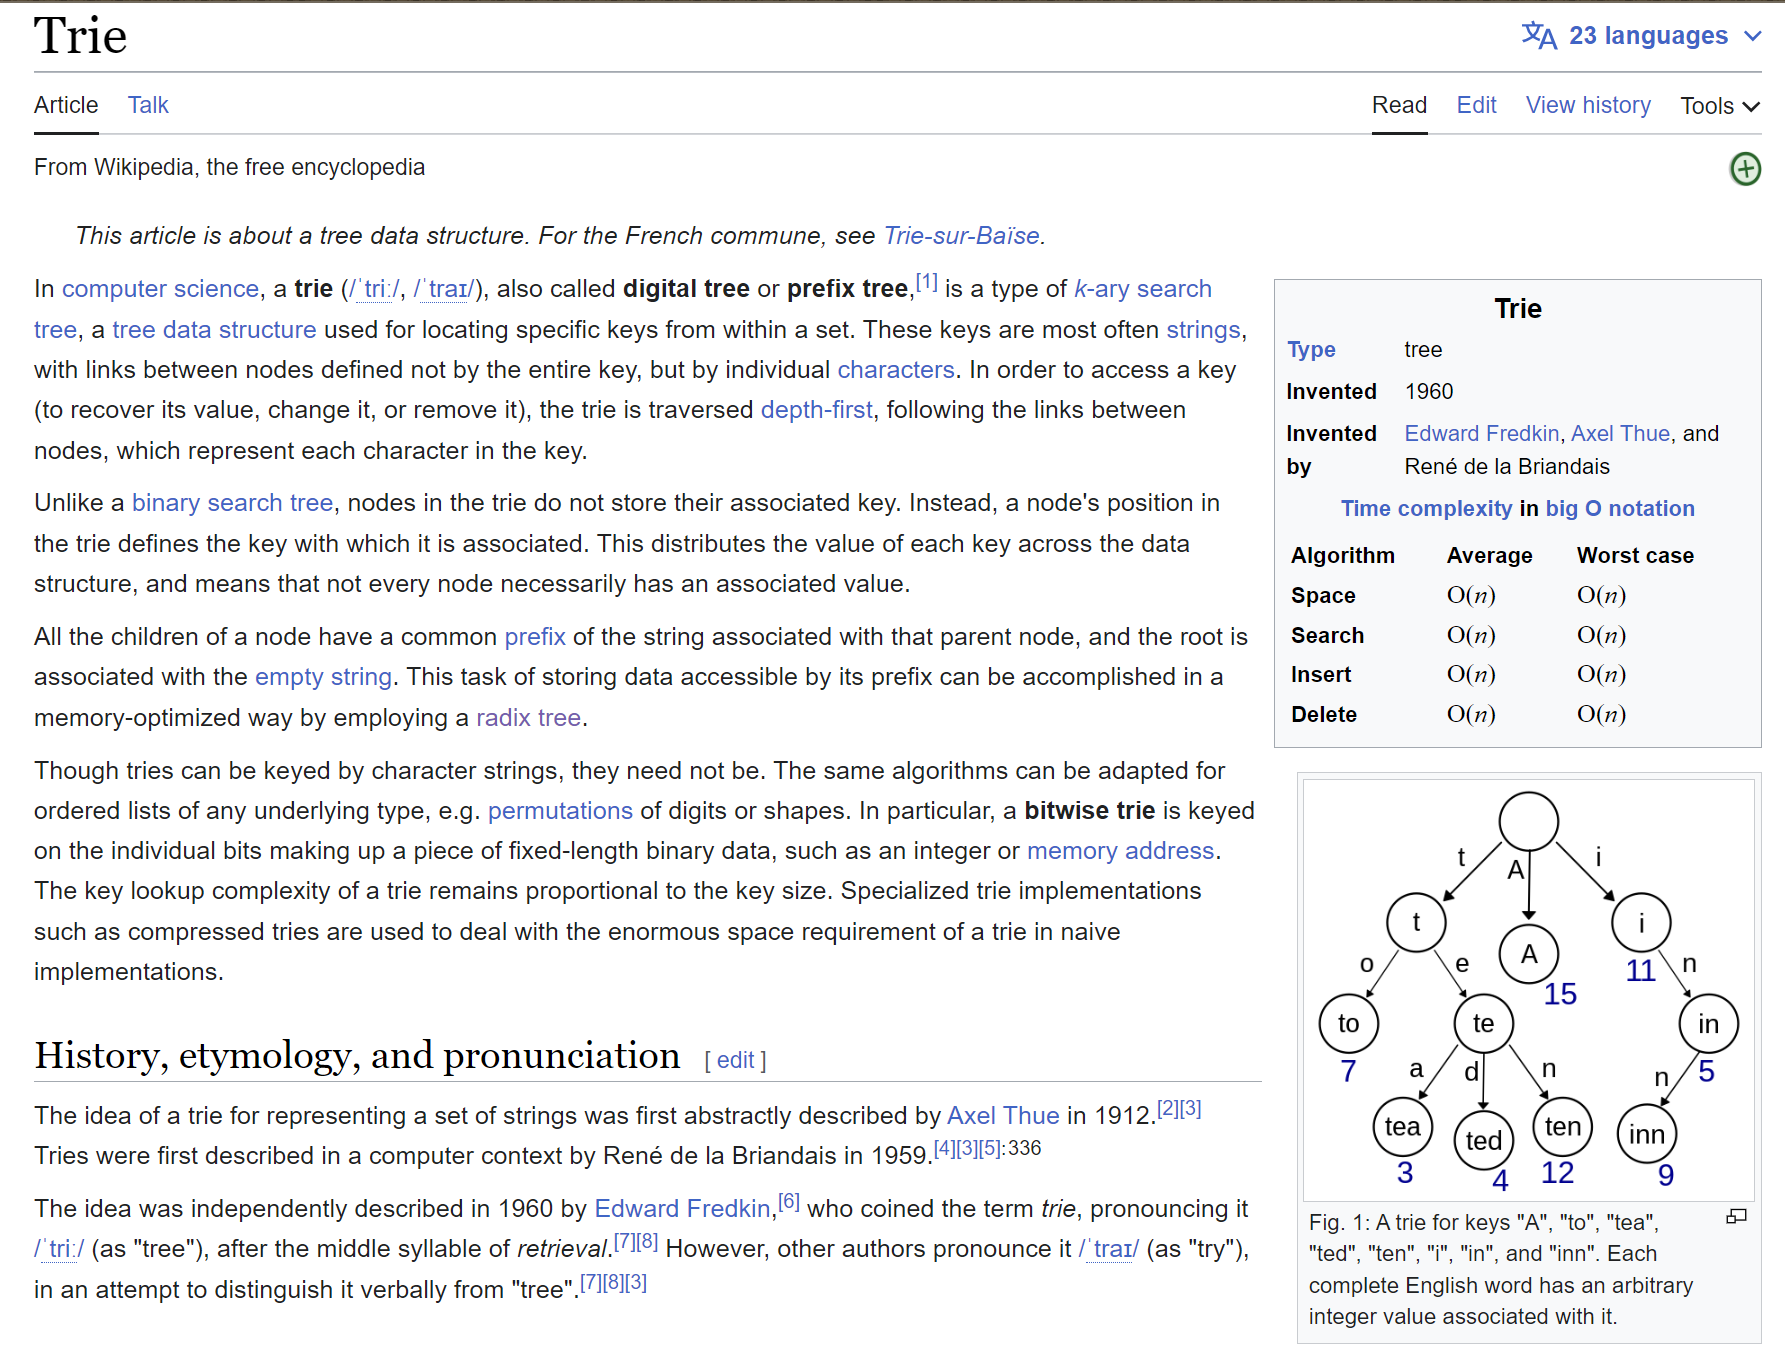
<br>
2. **Bloom Filter:** [Not a good option] A Bloom filter is a probabilistic data structure that can efficiently test whether an element is a member of a set. It uses a bit array and multiple hash functions to store and check for the presence of elements. Bloom filters are very memory-efficient but can have false positives.
https://en.wikipedia.org/wiki/Bloom_filters_in_bioinformatics
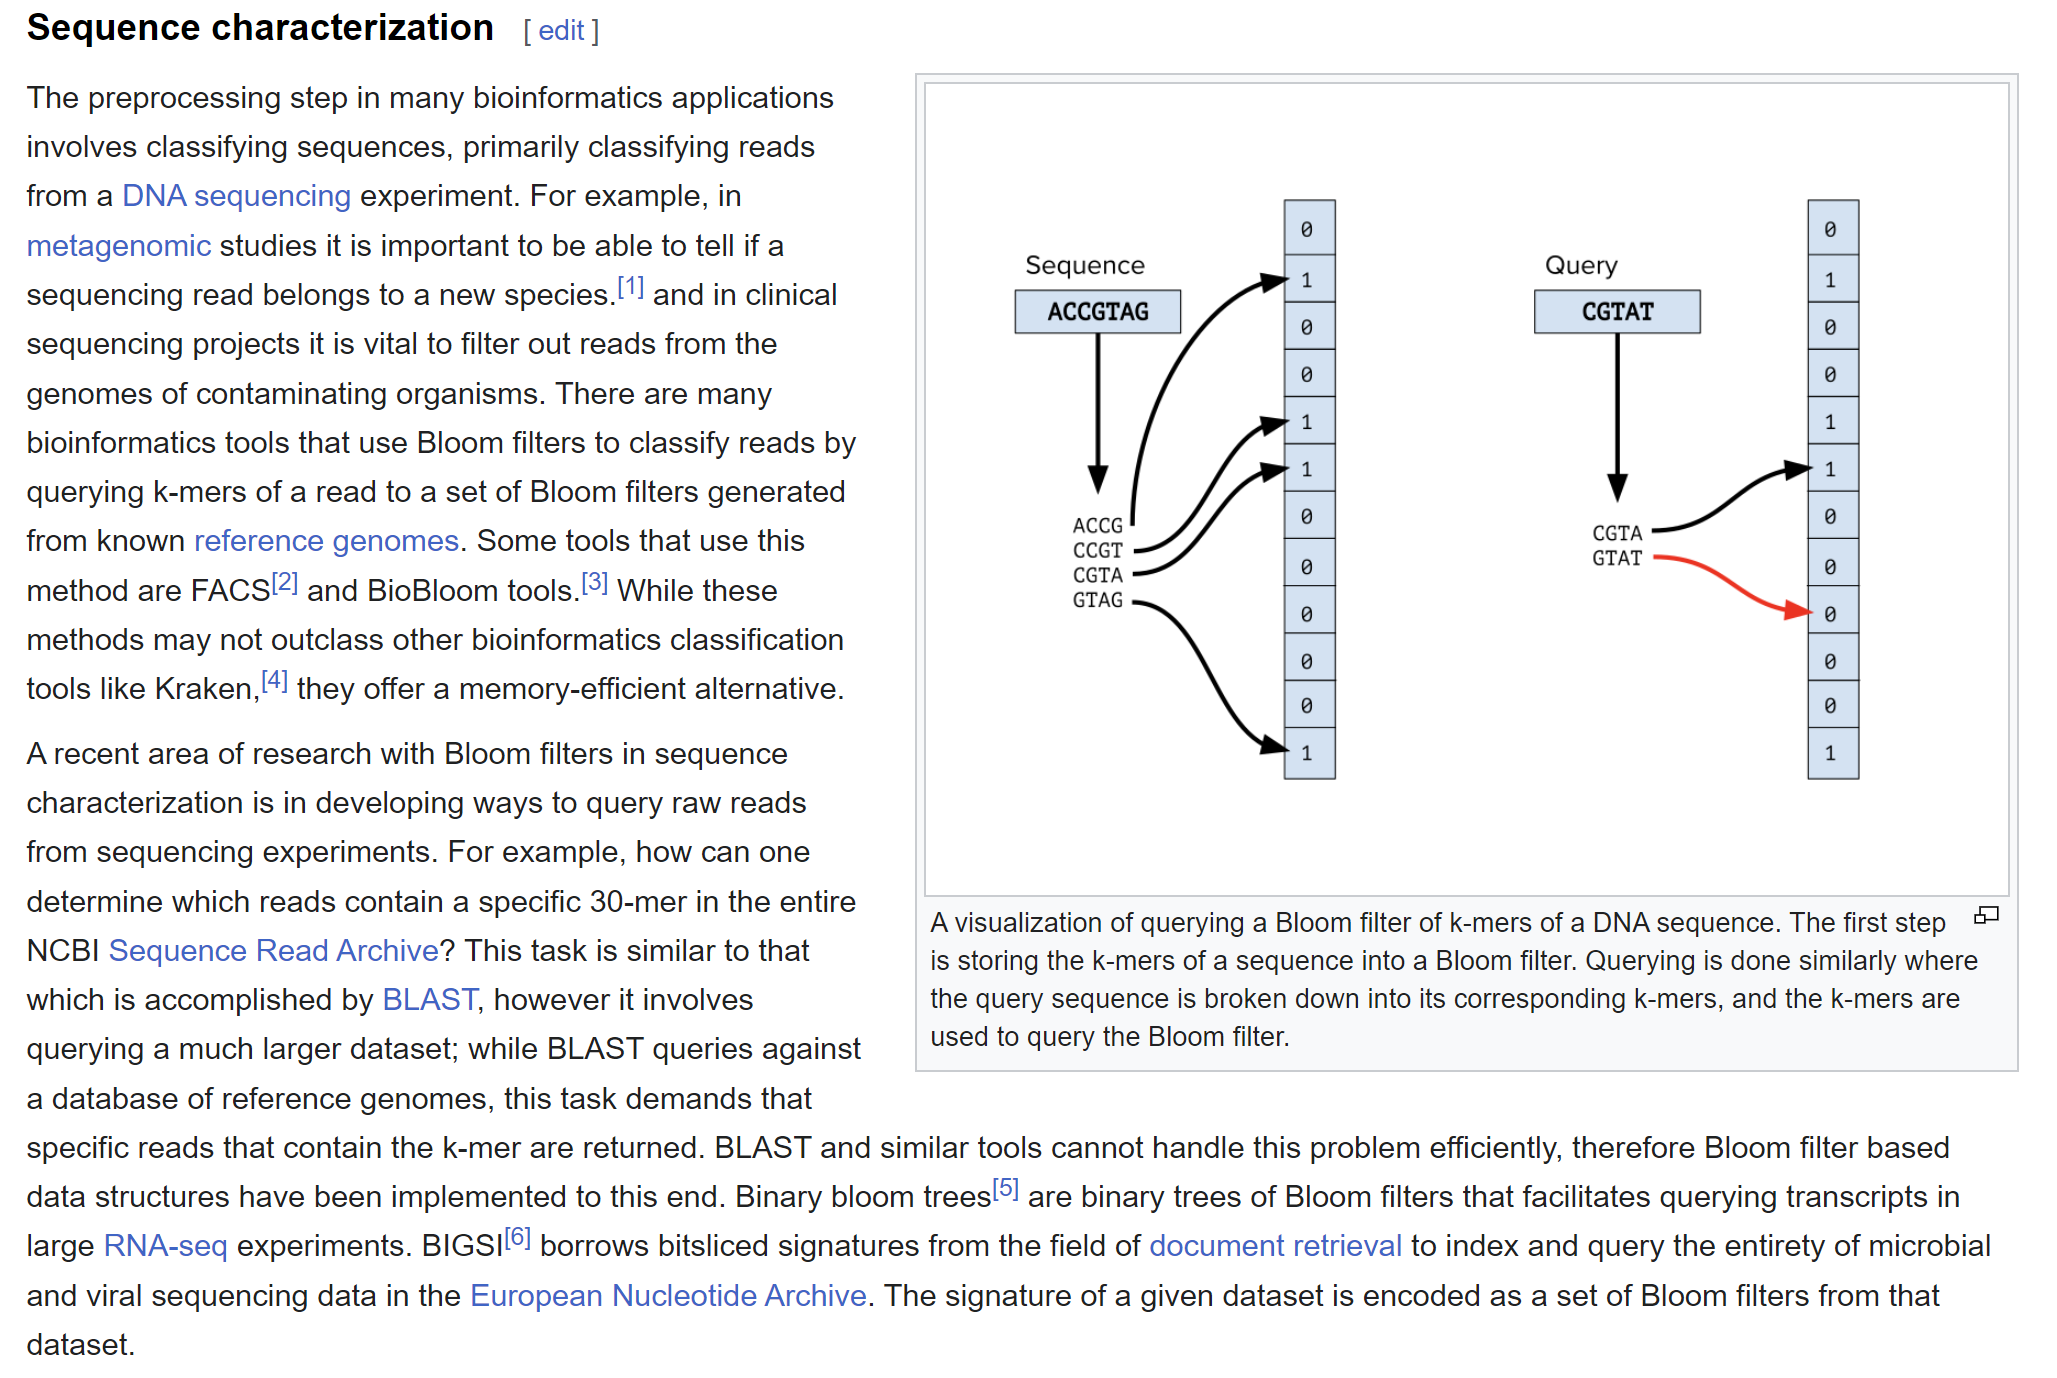
<br>

3. **Suffix Array:** [Not a good option] A suffix array is an array of all suffixes of a given text. It is commonly used for substring searches in text data. While it can be memory-intensive compared to some other data structures, it is efficient for substring searches and can be compressed to reduce memory usage.
https://en.wikipedia.org/wiki/Suffix_tree
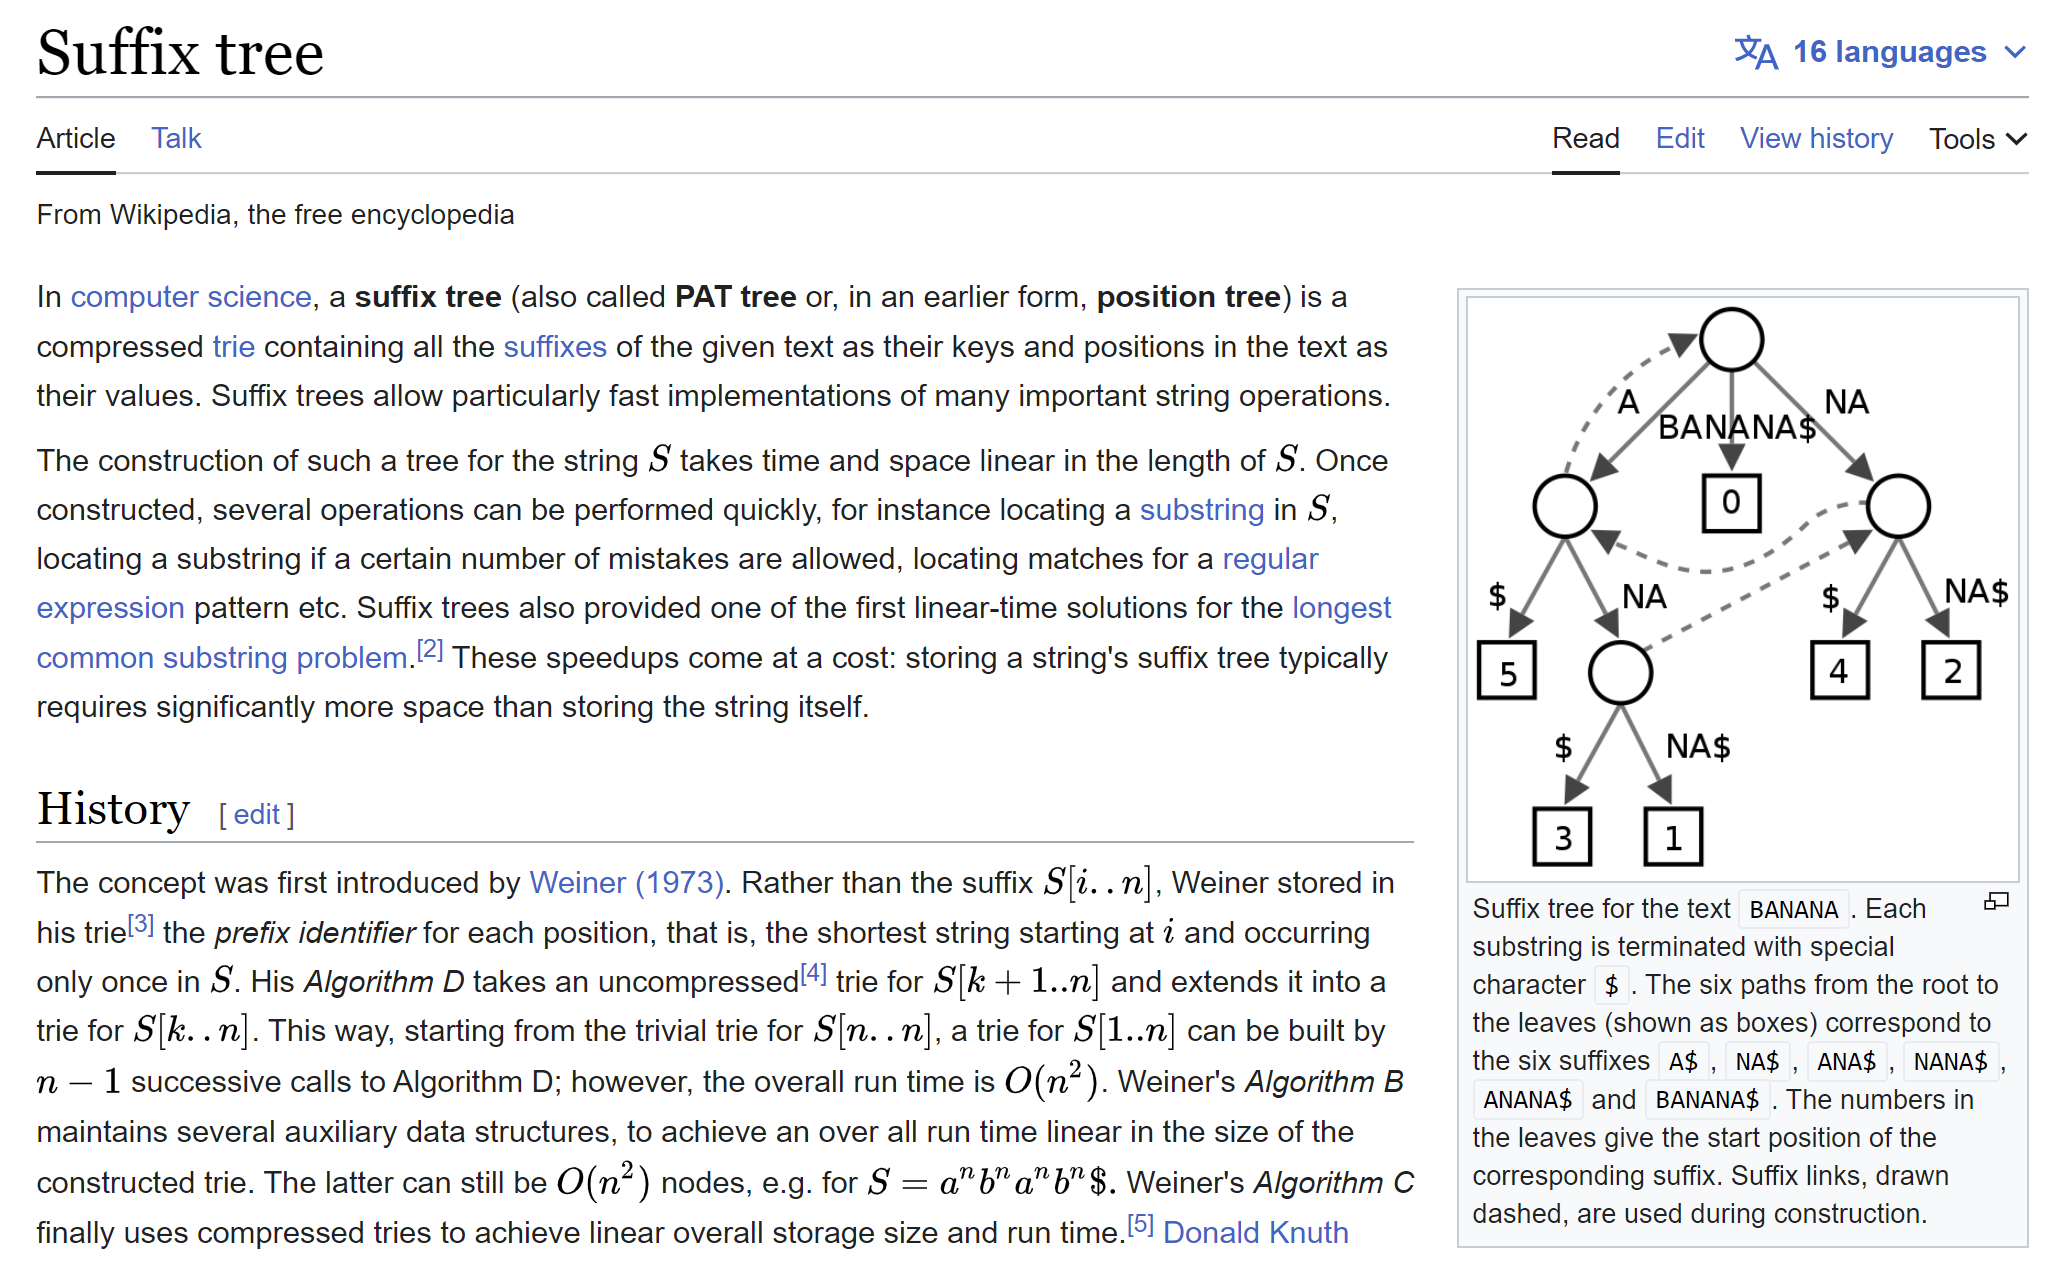
<br>

4. **Compressed Trie or Patricia Trie:** [Very valid option] These are variations of tries that aim to reduce memory consumption by compressing common prefixes. They maintain the quick search capabilities of a trie while optimizing memory usage.
https://en.wikipedia.org/wiki/Radix_tree
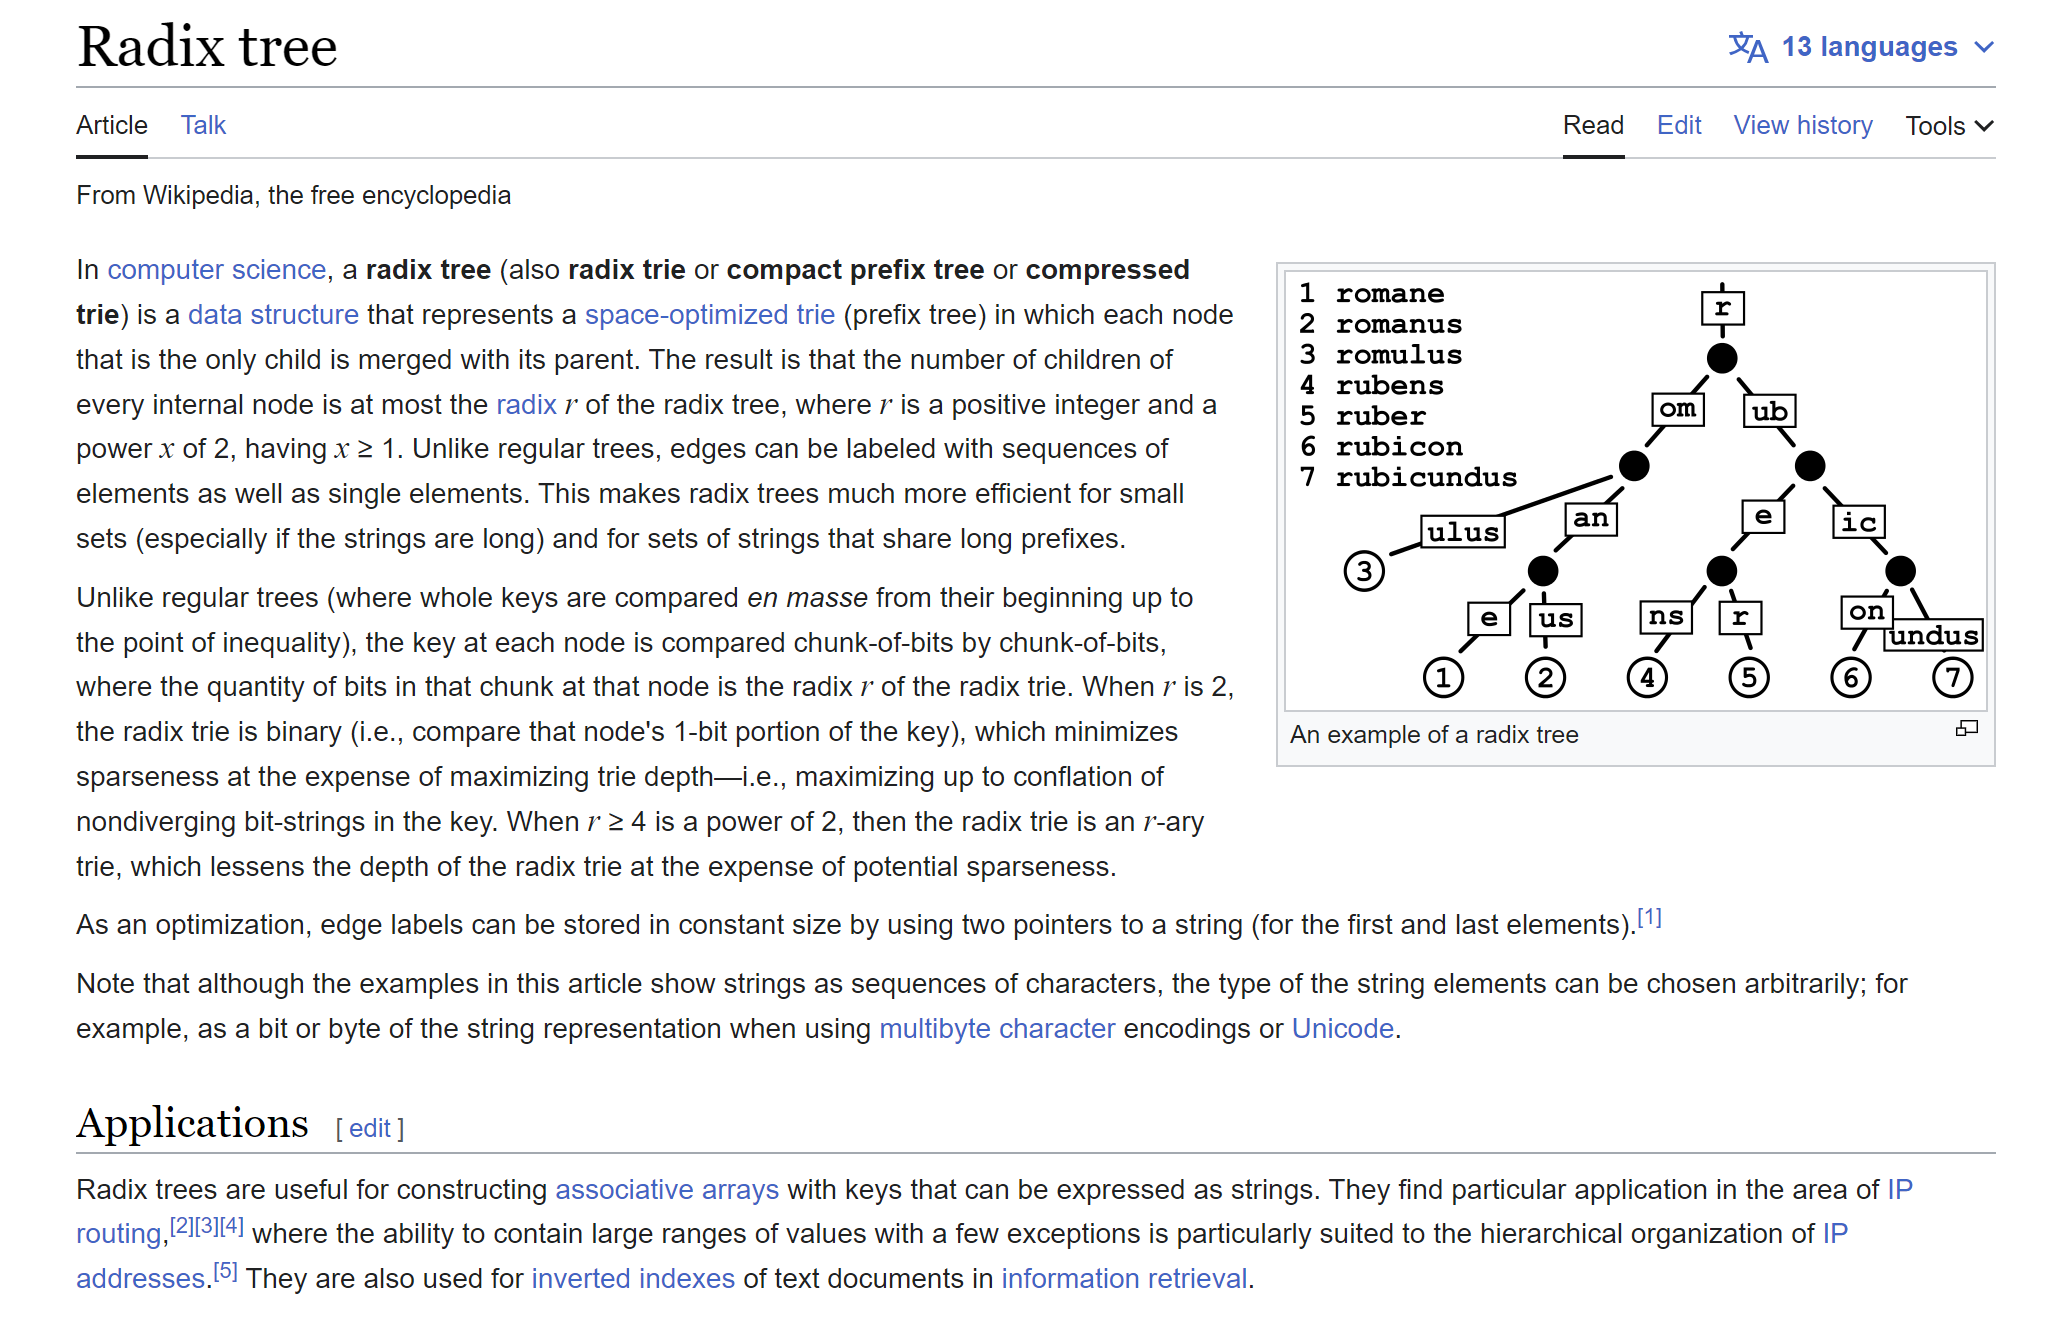
<br>

5. **Hash Table:** [Very valid option, especially if we use an indexed list of aliases as the "buckets" to the naming "keys"] A hash table can be used to store words as keys and their associated data as values. Hash tables provide fast lookup times on average, but their memory efficiency depends on the hash function and collision resolution strategy. They can be memory-efficient when properly tuned.
https://en.wikipedia.org/wiki/Hash_table
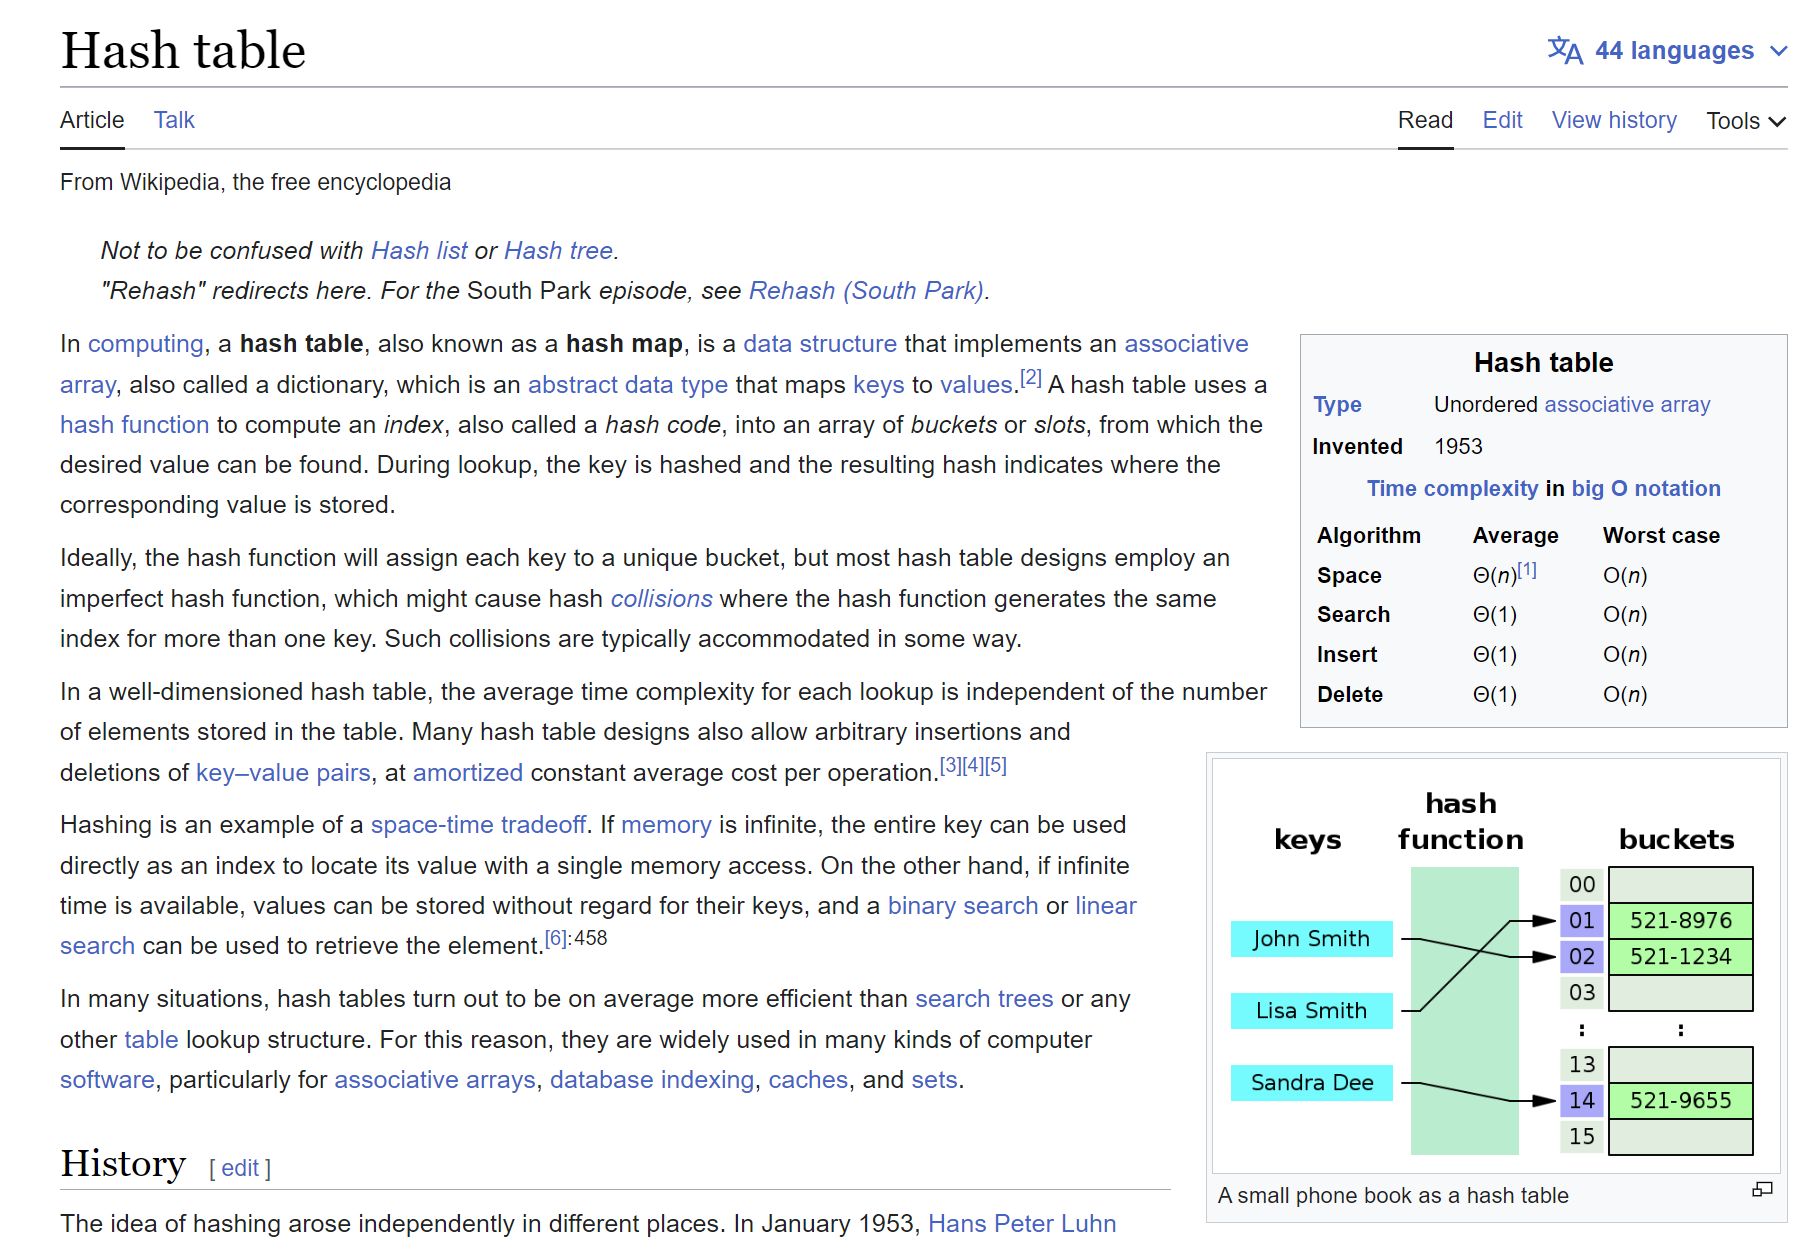
<br>

6. **Wavelet Tree:** A wavelet tree is a tree-based data structure used for searching and querying text data. It can be memory-efficient for certain types of searches, especially when dealing with a large alphabet (e.g., DNA sequences).
https://en.wikipedia.org/wiki/Wavelet_Tree
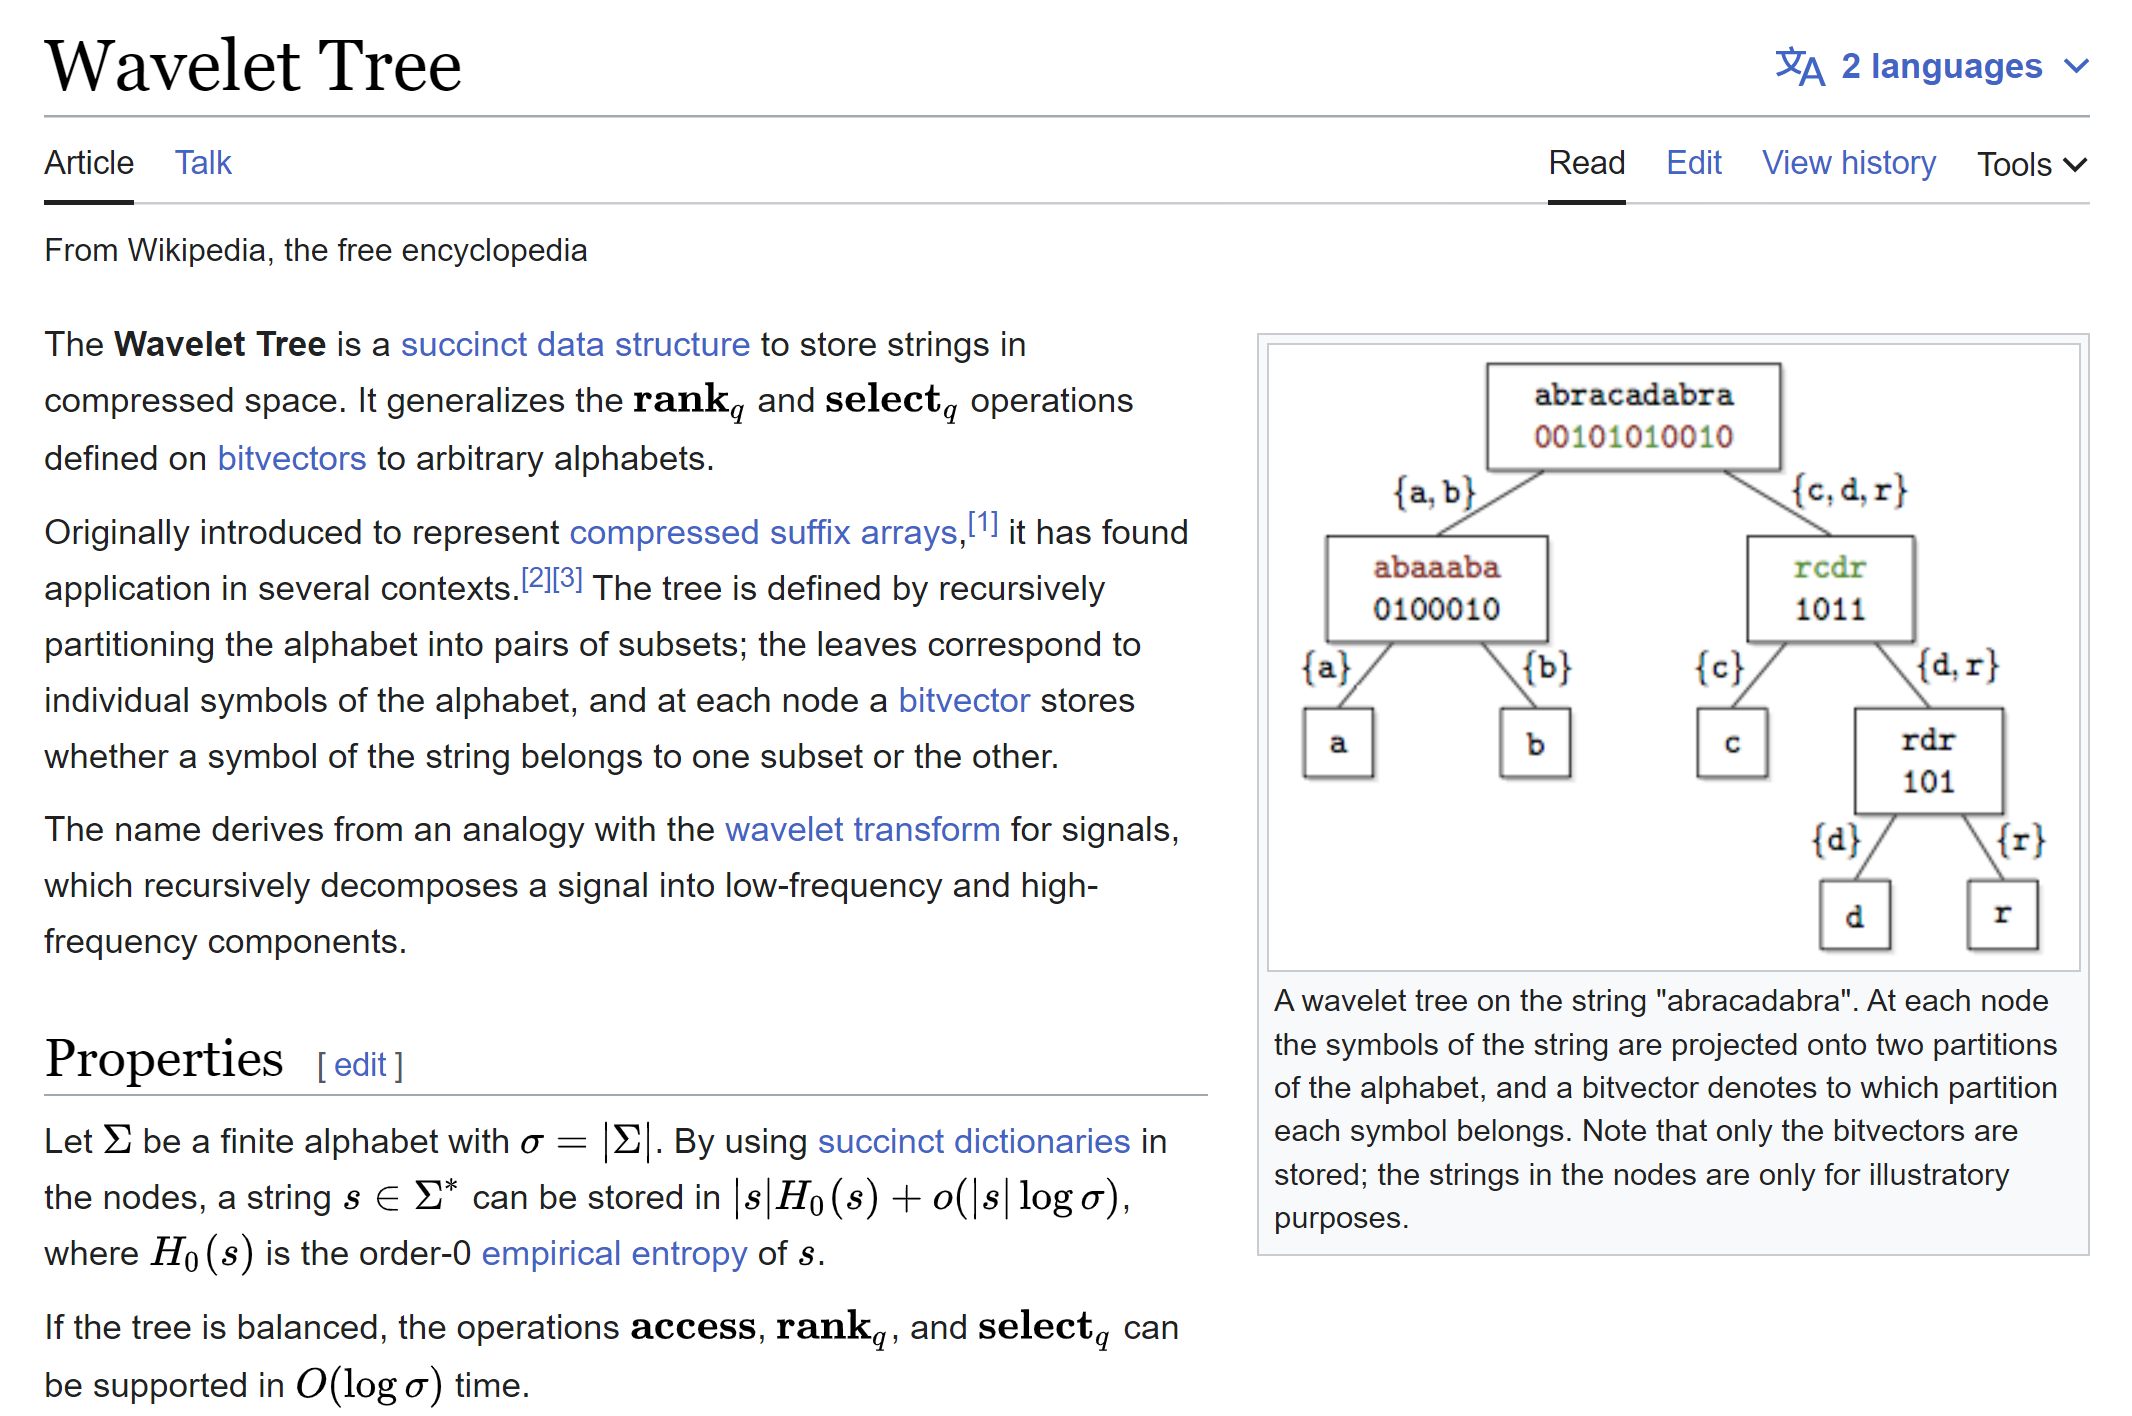
<br>

7. **Burrows-Wheeler Transform (BWT):** BWT is a reversible transformation applied to text data that often leads to more compressible representations. It is commonly used in conjunction with other data structures or compression algorithms.
https://medium.com/@mr-easy/burrows-wheeler-transform-d475e0aacad6
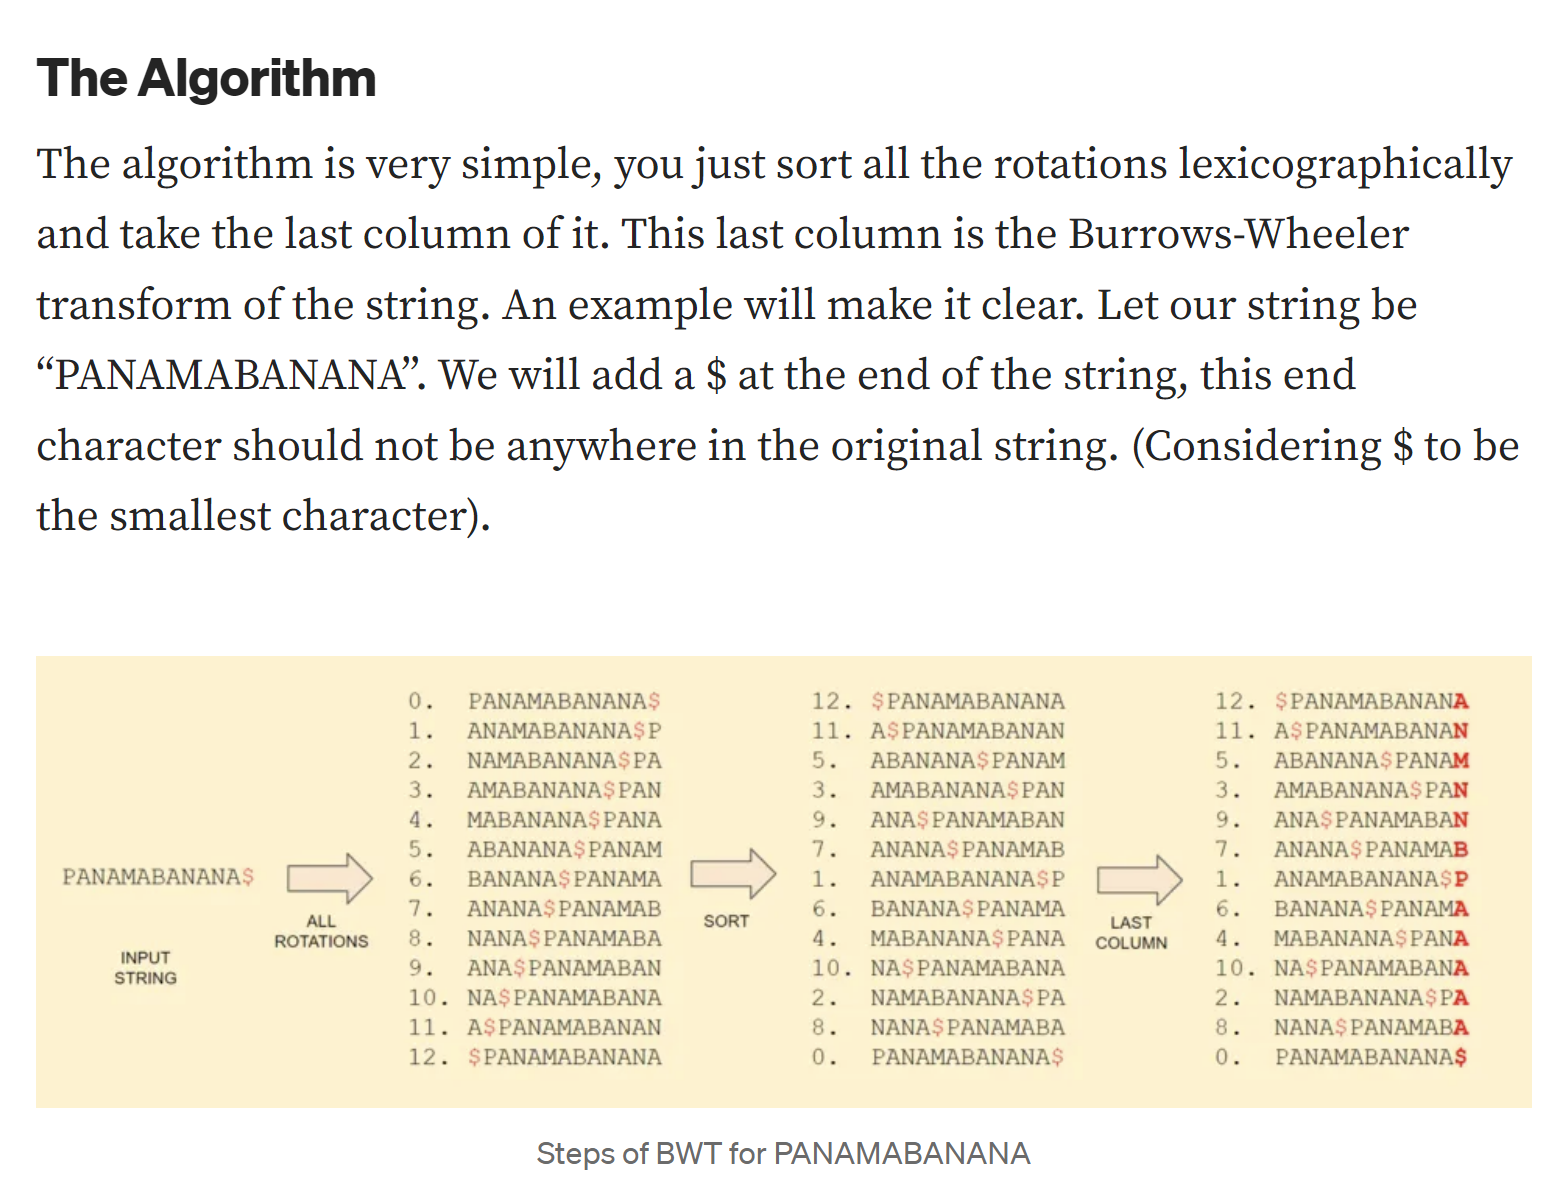
<br>

8. **Compact Data Structures:** [not really an option, unless willing to delve into C to implement under Python...] Other various compact / succinct data structures are designed to store data efficiently, often using bitwise operations. These structures can be very memory-efficient but may require more complex code to implement and query.



### My Data Structuring Approach for the SOAM


## Data Structuring Workflow
* **Start by compiling catalogs to include in the SOAM and recognize the catalog identifier ('M' for Messier, 'Sh2' for Sharpless, etc.:**
    * **Messier Catalog** – [INCLUDE ALL] The Messier objects are a set of astronomical objects first listed by French astronomer Charles Messier in 1771. Nebulae and Star Clusters was published in 1781, with objects M1 – M110. -- messier:['messier','m']
    * The **Index Catalogue** (IC) —also known as the Index Catalogue of Nebulae, the Index Catalogue of Nebulae and Clusters of Stars, IC I, or IC II— is a catalogue of galaxies, nebulae and star clusters that serves as a supplement to the New General Catalogue. It was first published in 1895, and has been expanded to list more than 5,000 objects, known as the IC objects. -- ic:['ic']
    * **New General Catalogue** [INCLUDE TITLE TEXT GUIDED SELECTION] compiled in the 1880s by J. L. E. Dreyer, lists objects NGC 0001 – NGC 7840. The NGC is one of the largest historical comprehensive catalogs, as it includes all types of non-stellar deep space objects. -- ngc:['ngc','new general']
    * Henry Draper's **Henry Draper Catalogue**, [INCLUDE ONLY NAMED STARS and TITLE TEXT GUIDED SELECTION] published between 1918 and 1924, lists more than 225,000 of the brightest stars, named using HD followed by a 6-digit number. -- hd:['hd','henry draper']
    * Sir Patrick Moore compiled the **Caldwell catalogue** [INCLUDE ALL] in 1995 to complement the Messier catalog, listing 109 bright star clusters, nebulae, and galaxies named C1 to C109. This is a list of deep-sky objects of interest to amateur astronomy and not a catalog in the professional science sense. Other deep-sky observing lists for amateur astronomers predated it. -- caldwell:['caldwell','c']
    * The **Gum catalog** [INCLUDE ALL] is an astronomical catalog of 84 emission nebulae in the southern sky. It was made by the Australian astronomer Colin Stanley Gum (1924-1960) -- gum:['gum','g']
    * The **Sharpless catalog** [INCLUDE ALL] is a list of 313 H II regions (emission nebulae) intended to be comprehensive north of declination −27°. (It does include some nebulae south of that declination as well.) The first edition was published in 1953 with 142 objects (Sh1), and the second and final version was published by US astronomer Stewart Sharpless in 1959 with 312 objects. Sharpless also includes some planetary nebulae and supernova remnants, in addition to H II regions.[1] -- sh2:['sharpless','sh2']
    * The **RCW Catalogue** (from Rodgers, Campbell & Whiteoak) [INCLUDE ALL] is an astronomical catalogue of Hα-emission regions in the southern Milky Way, described in (Rodgers et al. 1960). It contains 182 objects, including many of the earlier Gum catalogue (84 items) objects. -- rcw:['rcw']
* **Then scrape the title data for some most popular cataloged object ID descriptions**

In [ ]:
#EXPLORATION -- review cleaned title data for most popular catalog IDs

## -- first, a dict to help recognize catlog IDs
catalog_tags = {
    'messier':['messier','m'],
    'ic':['ic','index'],
    'ngc':['ngc','new general'],
    'hd':['hd','henry draper'],
    'caldwell':['caldwell','c'],
    'gum':['gum'],
    'sh2':['sharpless','sh2'],
    'rcw':['rcw']
}

## -- then, lets merge all tags into a check list
checklist = [x for every_x in catalog_tags.values() for x in every_x]
checklist

['messier',
 'm',
 'ic',
 'index',
 'ngc',
 'new general',
 'hd',
 'henry draper',
 'caldwell',
 'c',
 'gum',
 'sharpless',
 'sh2',
 'rcw']

In [ ]:
## -- then, we understand the following and apply it to a regex search of each 1 and 2 ngram
#  -- -- each tag should be followed by a series of number characters [0-9]
#  -- -- each series of number characters of an objects ID will end with a non-numeric character.                 
#  -- -- this will not capture multiple IDs that were 'cleverly' written like:
#        "Messier 24,16,17 and m23" (our regex will only catch "Messier 24" and "m23")
import re
#HELPER METHOD -- regex for catalog patterns in titles, default values are only for testing purposes
def id_search(tags = ['messier','m'], s = "This string 'messier 24,16, 17 and m23, m-05' will not return 16 nor 17"):      
    #ASSUMES tags and s are cleaned accordingly (cap sensitive)
    # Create a regular expression pattern with capturing groups for the keyword and numeric characters
    pattern = r'(' + '|'.join(re.escape(keyword) for keyword in tags) + r')\D*(\d+)'
    # Use re.findall to find all matching substrings
    matches = re.findall(pattern, s)
    # return the matched keyword and numeric characters
    return([' '.join(match) for match in matches])

#TEST
id_search()

['messier 24', 'm 23', 'm 05']

In [ ]:
#WORK -- pull IDs from title data
title_ids = [id_search(tags = checklist, s = x) for x in df.cleaned_title] #collect id_search results, includes empty '[]' and nested '[A, B]'      
title_ids = [x for every_x in title_ids for x in every_x] #remove empties  and un-nest values, still contains duplicates
title_ids = set(title_ids) #removes duplicates and makes title ids a set
#title_ids #we now have a set of IDS listed from titles data (some ids are still nonsence, like 'm 20190716')    

In [ ]:
#TITLE ASSISTED SELECTIONS
ngc_selections = [x for x in title_ids if 'ngc' in x]+[x for x in title_ids if 'new' in x]
ic_selections = [x for x in title_ids if 'ic' in x]+[x for x in title_ids if 'index' in x]
hd_selections = [x for x in title_ids if 'hd' in x]+[x for x in title_ids if 'draper' in x]

print(f'NGC catalog occurrences: {len(ngc_selections)}')
print(f'IC catalog occurrences: {len(ic_selections)}')
print(f'Henry Draper catalog occurrences: {len(hd_selections)}')   

print("--- START CLEANING ---")
#... these selections still need to be cleaned", but the rules of these cleanings may differ between the catalog selection types 
#simple cleaning -- filtering out the values that are obviously too long to be real ids
ngc_selections = [x for x in ngc_selections if len(x)<=8] 
ic_selections = [x for x in ic_selections if len(x)<=7]
hd_selections = [x for x in hd_selections if len(x)<=9]

print(f'NGC catalog occurrences: {len(ngc_selections)}')
print(f'IC catalog occurrences: {len(ic_selections)}')
print(f'Henry Draper catalog occurrences: {len(hd_selections)}')  
print("--- END CLEANING ---")


NGC catalog occurrences: 2757
IC catalog occurrences: 837
Henry Draper catalog occurrences: 160
--- START CLEANING ---
NGC catalog occurrences: 2738
IC catalog occurrences: 805
Henry Draper catalog occurrences: 159
--- END CLEANING ---


## Basic idea for the SOAM
* There will be two dict structures; a large names dict, and a smaller indexed alias dict
* The `names` dict will contain the names of all included objects in the SOAM and will be structured something like the following, where the key is the name and the value is an int which will refer to an index number in the alias dict (names structure may become nested to help speed up retreival):

In [ ]:
names = {
    "m 31":1,
    "andromeda galaxy":1,
    "horse head nebula":2,
    "ngc 224":1
}

* The `alias` dict  will contain index keys and value pairs of alias lists (where each list is a unique collection of names for resepective space objects) 

In [ ]:
aliases = {
    1:["m 31", "andromeda galaxy", "ngc 224"],
    2:["horse head nebula"]
}

### SOAM Class

In [ ]:
import re
import string
import json

#This can be passed to the SOAM so there is control over what type of cleaning we do...
def provided_cleaning_method(s):
    #standardize on lower case
    s = s.lower()
    #put a space between each alpha and numeric ("abc123" becomes "abc 123")
    s = re.sub(r'([a-z])(\d)', r'\1 \2', s)
    #put a space between each numeric and alpha ("123abc" becomes "123 abc")
    s = re.sub(r'(\d)([a-z])', r'\1 \2', s)
    #replace all punctuation with a space (' '), except for the apostraphe "'"
    s = re.sub(r'[^\w\s\']', ' ', s)
    #trim all leading and trailing white space
    s = s.strip()
    #replace double spaces with single space
    s = re.sub('  ', ' ', s)
    #TESTING---------
    #print(s)
    #----------------
    return(str(s))

provided_tag_priorities = ["m ", "ngc ", "ic "]
provided_common_name_tags = ["galaxy"]

class Soam:
    """
    The SOAM class is a "Space Object Alias Map". 
    It assumes each association that shares at least one name is a unique object.
    Once instantiated...
    Pass in a list of associations using the 'add_associations' method 
        -- associations being a sub list of related names: 
            [['m31','andromeda galaxy'],['b33','horse head nebula']]
        -- if 'cleaning method = False' 
            then it expects all associations to be pre-cleaned 
                (remove unwanted punct. and the like)
            otherwise it will clean all inputs according to the passed method...
    Builds three dicts (all standardized according to the cleaning method):
        -- The names dict will contain the names of all included objects in the SOAM and will
            be structured something like the following, where the key is the name and the value
            is an int which will refer to an index number in the alias dict.
        -- The alias dict will contain index keys and value pairs of alias lists
            (where each list is a unique collection of names for resepective space objects)
        -- The standard names dict will include the selected standard name from among all aliases
            this will always prioritize the longest all alpha character name (no numbers, no punctuation)
            additional prioritization can be prompted by setting prioritized_catalog_tags when creating your SOAM
            default prioritized_catalog_tags = ["m", "ngc", "ic"] 
    EXAMPLE:
        t = Soam()
        associations = [["a","b","c"],["c","d"],["e","f"]]
        t.add_associations(associations)
        print(t.all_names())
        print(t.all_aliases())
        print(f"'c' is also known as {t.get_aliases('c')}")
    RETURNS:
        {'d': 0, 'b': 0, 'a': 0, 'c': 0, 'f': 1, 'e': 1}
        {0: {'d', 'b', 'a', 'c'}, 1: {'f', 'e'}}
        'c' is also known as {'d', 'b', 'a', 'c'}
        
    SEARCH FOR ALIASES
        get_aliases
    """
    #Instantiate
    def __init__(self, cleaning_method = provided_cleaning_method, prioritized_common_name_tags = provided_common_name_tags, prioritized_catalog_tags = provided_tag_priorities):
        print("SOAM Started ---------------- ")
        self.names={}
        self.aliases={}
        self.standard_names = {}
        self.cleaning_method = cleaning_method
        self.prioritized_catalog_tags = prioritized_catalog_tags
        self.prioritized_common_name_tags = prioritized_common_name_tags
        s_test = "   #][!,@ ^&*NGc224-.99+9abc. ...   " # a messy string to test
        if self.cleaning_method != False:
            try:
                print("SOAM Cleaning Method Test -- ")
                print(f'original test string: "{s_test}"')
                print(f'cleaned test string: "{cleaning_method(s_test)}"')
            except Exception as e:
                print("Provided cleaning method must accept a single string arg.")
                print(e)
    #Methods
    def __str__(self):
        """For simple printing description of the SOAM."""
        return f'{len(self.names)} names / aliases mapped across {len(self.aliases)} objects.'
    def all_names(self):
        """Returns the names dict structure"""
        return(self.names)
    def all_aliases(self):
        """Returns the aliases dict structure"""
        return(self.aliases)
    def all_standard_names(self):
        """Returns the standard_name dict structure"""
        return(self.standard_names)
    def common_items(self,set1,set2):
        """
        Pass two lists that potentially contain identical items
        Returns true if any items match between the two lists, false if none
        """
        return(any(item1 == item2 for item1 in set1 for item2 in set2))  
    def next_available_key(self):
        """return the next available key value for a unique alias set"""
        keys = sorted(self.aliases.keys())
        i = 0
        key_found = False
        while not key_found and i<len(keys):
            key_found = keys[i] != i
            i = i + 1
        if key_found:
            i = i - 1
        return(i) # i is the next available key
    
    def set_standard_names(self):
        for alias_key in self.all_aliases():
            #each alias keyed set will have a name prioritized as the "standard name"
            prioritized_name = "" 
            #get the current looped set
            alias_set = self.all_aliases()[alias_key]
            #check if there are any strictly alpha-only strings (like a common name)
            alpha_options = [s for s in alias_set if not bool(re.search(r'\d', s))]
            if len(alpha_options)>0: #if there is strictly alpha-only string(s)
                for tag in self.prioritized_common_name_tags: #loop through each common name tag prioritized
                    for name in alpha_options: #loop and check out each name in the current alias set alphas
                        if tag in name: 
                            #if the prioritized tag was found in the name
                            prioritized_name = name #...that name should be prioritized
                            break
                    if prioritized_name != "": # if the prioritized name has been filled
                        break # ... break the common name loop
                if prioritized_name == "": #if the prioritized still has not been filled then...
                    #...return the longest one
                    prioritized_name = max(alpha_options,key=len)
            else:
                for tag in self.prioritized_catalog_tags: #loop through each catalog tag prioritized
                    for name in alias_set: #loop and check out each name in the current alias set 
                        if name.startswith(tag): 
                            #...then make the first tagged name the prioritized standard name 
                            prioritized_name = name
                            break # then break the alias name loop
                    if prioritized_name != "": # if the prioritized name has been filled
                        break #then break out of the tag loop
                if prioritized_name == "": # if the prioritized name has NOT been filled
                    #then just take the first, non-min/max, alias name stored as the standard name
                    lengths = [len(name) for name in alias_set]
                    if len(lengths)>2: #the following loop will need more than 2 name s to work (the min and max rule will cause issue with only two names)              
                        for name in alias_set:
                            if (len(name) != min(lengths)) and (len(name) != max(lengths)):
                                prioritized_name = name
                                break #stop looking, the standard name is found
                    else: #we have exhausted all priority options...
                        #... just take the smallest name out of the one or two alias options
                        prioritized_name = min(alias_set,key=len)
                        
                if prioritized_name == "": #if, for whatever reason, we still have no prioritized standard name
                    #take the first name in the aliase set as the "standard name"
                    prioritized_name = list(alias_set)[0]
            #set the standard name at the corresponding key of the alias set...
            self.standard_names[alias_key] = prioritized_name
        
    
    def add_associations(self,associations):
        """
        Pass in a list of associations
        """
        for association_set in associations:
            #association_set = set(association_set) #standardize the passed association as a set
            #if a cleaning method was passed in... 
            if self.cleaning_method != False:
                association_set = {self.cleaning_method(name) for name in association_set} 
            else:
                association_set = set(association_set)
            #set up some helper variables
            # To store all indexes of alias sets that have a common item with the current association
            found_matches = [] 
            #loop through each alias set in current aliases
            for alias_key in self.aliases:
                alias_set = set(self.aliases[alias_key])
                #... and compare the looped alias set to the current association set
                if self.common_items(alias_set,association_set):
                    # ...if there is a common item,
                    found_matches.append(alias_key) #... then append the key of the alias set to found matches
            #Once all matches are found...
            found = len(found_matches)>0
            if found: #Then we need to merge all associated aliase key points found with matches
                #... merge the common aliases into the first most found match key of the alias sets
                merge_point = found_matches[0]
                # ... and note the points you need to delete once merged...
                delete_points = set(found_matches[1:]) # make it a set to remove duplicate matches
                # Loop through and merge all alias set key points to the merge point...
                for point_merging in delete_points:
                    self.aliases[merge_point] = self.aliases[merge_point]|self.aliases[point_merging]
                    #... then delete the alias key point that was merged at the merge point
                    del self.aliases[point_merging]
                    
                #Now, finally merge the current association to the alias set merge point
                self.aliases[merge_point] = self.aliases[merge_point]|association_set
            else: # This is a new associated set of names unique from all other alias sets. 
                #(new object found!)
                self.aliases[self.next_available_key()] = association_set

        #make a new names dict from the aliases dict
        self.names = {inner_value: key for key, value in self.aliases.items() for inner_value in value}
        
        #set all standard names from all the alias sets
        self.set_standard_names()
        
    def get_aliases(self,name):
        """returns all aliases associated with the passed name"""
        name = self.cleaning_method(name)
        try:
            return(self.aliases[self.names[name]])
        except KeyError:
            print(f"Alias names not found for '{name}'")
            
    def get_standard_name(self,name):
        """returns the standard name associated with the passed name"""
        name = self.cleaning_method(name)
        try:
            return(self.standard_names[self.names[name]])
        except KeyError:
            print(f"Standard name not found for '{name}'")
    
    def export_soam(self,file_location = "data/", file_name = "my_exported_soam"):
        #WE need to have a set encoder to make all sets into a list for json ----------
        def set_encoder(obj):
            if isinstance(obj, set):
                return list(obj)
            raise TypeError(f"{obj} is not JSON serializable")
        # -----------------------------------------------------------------------------
        file_name = file_name+".json"
        file_location = file_location+file_name
        with open(file_location, 'w') as json_file:
            json.dump(self.aliases, json_file, default=set_encoder)
            
    def import_soam(self,file_location = "data/", file_name = "my_exported_soam"):
        #reset aliases, names, and standard names to the imported soam values
        self.aliases = {}
        self.names = {}
        self.standard_names = {}
        
        file_name = file_name+".json"
        file_location = file_location+file_name
        with open(file_location, 'r') as json_file:
            imported_aliases = json.load(json_file)
        
        #ADD IN IMPORTED ALIASES
        if self.cleaning_method != False:
            for key, names in imported_aliases.items():
                self.aliases[key] = {self.cleaning_method(name) for name in names}
        else:
            for key, names in imported_aliases.items():
                self.aliases[key] = set(names)
        
        #ADD IN IMPORTED NAMES
        #make a new names dict from the aliases dict
        self.names = {inner_value: key for key, value in self.aliases.items() for inner_value in value}
        
        #ADD IN IMPORTED NAMES
        #set all standard names from all the alias sets
        self.set_standard_names()

        
            

In [ ]:
test_soam = Soam()

associations = [["M31", "M31", "Andromeda Galaxy", "andromeda nebula"], 
                ["M 31", "NGC 224", "NGC 225"],
                ["cat","dog"],
                ["M31", "NGC 224"], 
                ["dog","NGC 224"],
                ["pluto", "planet?999"],
                ["planet'x","mars"],
                ["super"],["bees"],
                ["pluto", "planetx"]]
test_soam.add_associations(associations)
test_soam.export_soam()
other_soam = Soam()
other_soam.import_soam()
print(test_soam)
other_soam.add_associations([["associatin","ocean","m31"]])
print(other_soam)

SOAM Started ---------------- 
SOAM Cleaning Method Test -- 
original test string: "   #][!,@ ^&*NGc224-.99+9abc. ...   "
cleaned test string: "ngc 224 99 9 abc"
SOAM Started ---------------- 
SOAM Cleaning Method Test -- 
original test string: "   #][!,@ ^&*NGc224-.99+9abc. ...   "
cleaned test string: "ngc 224 99 9 abc"
14 names / aliases mapped across 5 objects.
16 names / aliases mapped across 5 objects.


In [ ]:
#TESTING the SOAM
test_soam = Soam()

associations = [["M31", "M31", "Andromeda Galaxy", "andromeda nebula"], 
                ["M 31", "NGC 224", "NGC 225"],
                ["cat","dog"],
                ["M31", "NGC 224"], 
                ["dog","NGC 224"],
                ["pluto", "planet?999"],
                ["planet'x","mars"],
                ["super"],
                ["pluto", "planetx"]]
test_soam.add_associations(associations)
print(test_soam)
print("ALIASES -------- ")
print(test_soam.all_aliases())
print("NAMES ---------- ")
print(test_soam.all_names())

print()

associations = [["M31", "fish"],["uniquely cool"]]
test_soam.add_associations(associations)
print(test_soam)
print("ALIASES -------- ")
print(test_soam.all_aliases())
print("NAMES ---------- ")
print(test_soam.all_names())

print()

print(test_soam.all_standard_names())
print(test_soam.get_standard_name("m31"))


SOAM Started ---------------- 
SOAM Cleaning Method Test -- 
original test string: "   #][!,@ ^&*NGc224-.99+9abc. ...   "
cleaned test string: "ngc 224 99 9 abc"
13 names / aliases mapped across 4 objects.
ALIASES -------- 
{0: {'m 31', 'andromeda galaxy', 'dog', 'andromeda nebula', 'cat', 'ngc 225', 'ngc 224'}, 1: {'pluto', 'planet 999', 'planetx'}, 2: {'mars', "planet'x"}, 3: {'super'}}
NAMES ---------- 
{'m 31': 0, 'andromeda galaxy': 0, 'dog': 0, 'andromeda nebula': 0, 'cat': 0, 'ngc 225': 0, 'ngc 224': 0, 'pluto': 1, 'planet 999': 1, 'planetx': 1, 'mars': 2, "planet'x": 2, 'super': 3}

15 names / aliases mapped across 5 objects.
ALIASES -------- 
{0: {'m 31', 'andromeda galaxy', 'dog', 'andromeda nebula', 'cat', 'ngc 225', 'ngc 224', 'fish'}, 1: {'pluto', 'planet 999', 'planetx'}, 2: {'mars', "planet'x"}, 3: {'super'}, 4: {'uniquely cool'}}
NAMES ---------- 
{'m 31': 0, 'andromeda galaxy': 0, 'dog': 0, 'andromeda nebula': 0, 'cat': 0, 'ngc 225': 0, 'ngc 224': 0, 'fish': 0, 'pluto'

# Putting it all together...
Now that we have the SOAM class, Soam, we can pull together lists of associations and feed the SOAM.
* To build associations we have two "seed" sources of names:
    * The excel sheet with some pre-built associations of names
    * The list of scraped names from the titles data
* From the seed sources we can build the start to our SOAM
* Once we have the started SOAM, we can pull one name from each alias and query more names from astropy.
    * May need to figure out a way to prioritize which name to search from the alias set (m > ngc > ic > any?)
    * Will need to figure out how to clean up returned names from astropy before adding it all to the SOAM

#### SOAM Example:

In [ ]:
#My new SOAM
my_test_soam = Soam()
associations = [['m31','andromeda galaxy'],
                ['b33','horse head nebula'], 
                ['m31', 'm 31', 'ngc 224'],
                ['pluto']]
my_test_soam.add_associations(associations)
associations = [['c 1659 262',
                 'cd 26 11823',
                 'gcl 52',
                 'gcrv 9819',
                 'hd 153799',
                 'm 19',
                 'mwsc 2519',
                 'ngc 6273']]
my_test_soam.add_associations(associations)
#print("---THE SOAM---")
#print("The SOAM class assumes each association that shares at least one name is a unique object.")
print(my_test_soam)
#print("---NAMES---")
#print(f'my_test_soam.all_names() = {my_test_soam.all_names()}')
#print("---ALIASES---")
print(f'my_test_soam.all_aliases() = {my_test_soam.all_aliases()}')
#print("--- EXAMPLE ALIASE SEARCH ---")
#print(f'my_test_soam.get_aliases("m31") = {my_test_soam.get_aliases("m31")}')
print(f'my_test_soam.all_standard_names() = {my_test_soam.all_standard_names()}')

SOAM Started ---------------- 
SOAM Cleaning Method Test -- 
original test string: "   #][!,@ ^&*NGc224-.99+9abc. ...   "
cleaned test string: "ngc 224 99 9 abc"
14 names / aliases mapped across 4 objects.
my_test_soam.all_aliases() = {0: {'andromeda galaxy', 'm 31', 'ngc 224'}, 1: {'b 33', 'horse head nebula'}, 2: {'pluto'}, 3: {'gcrv 9819', 'mwsc 2519', 'cd 26 11823', 'hd 153799', 'ngc 6273', 'c 1659 262', 'm 19', 'gcl 52'}}
my_test_soam.all_standard_names() = {0: 'andromeda galaxy', 1: 'horse head nebula', 2: 'pluto', 3: 'm 19'}


### Some Pre-Built Associations
Loading in existing associations from excel "seed" into a new SOAM

In [ ]:
#My new SOAM
my_soam = Soam() #initiating my SOAM
file_path = "AstroCatelogues.xlsm" #the file containing all the "seed" associations

SOAM Started ---------------- 
SOAM Cleaning Method Test -- 
original test string: "   #][!,@ ^&*NGc224-.99+9abc. ...   "
cleaned test string: "ngc 224 99 9 abc"


In [ ]:
#Start Loading in various Catalogs with some associations
sheet_name = "Messier"
df = pd.read_excel(file_path,sheet_name)
select_cols = ["Messier number","NGC/IC number","Common name"]
listed_values = df[select_cols].values.tolist()
associations = [[item for item in sublist if item != '–'] for sublist in listed_values]

#Add the associations to the SOAM
my_soam.add_associations(associations)
print(my_soam)

282 names / aliases mapped across 109 objects.


In [ ]:
import math
sheet_name = "Caldwell"
df = pd.read_excel(file_path,sheet_name)
select_cols = ["Caldwell number","NGC number"]
listed_values = df[select_cols].values.tolist()
associations = [[item for item in sublist if item != '-' ] for sublist in listed_values]

#Add the associations to the SOAM
my_soam.add_associations(associations)
print(my_soam)

500 names / aliases mapped across 218 objects.


In [ ]:
sheet_name = "Planets_and_DwarfPlanets"
df = pd.read_excel(file_path,sheet_name)
# we need to change "(45) Eugenia I (Petit-Prince)" into ['', '45',' Eugenia I ', 'Petit-Prince', '' ]
associations = list(df["Body"].str.split(r'[\(\)]'))
#now we need to change ['', '45',' Eugenia I ', 'Petit-Prince', '' ] into ['Eugenia I', 'Petit-Prince']
associations = [[word.rstrip().lstrip() for word in sublist if (word != '') and not (word.isdigit())] for sublist in associations]

#Add the associations to the SOAM
my_soam.add_associations(associations)
print(my_soam)

693 names / aliases mapped across 411 objects.


In [ ]:
sheet_name = "Galactic Wolf Rayet"
df = pd.read_excel(file_path,sheet_name)
df['WR'] = "WR " + (df['WR#'])
select_cols = ["WR","HD","Alias1","Alias2","Alias3"]
listed_values = df[select_cols].astype(str).values.tolist()
#cleaning out the bad characters, removing 'nan's, and stripping out right hand spaces
listed_values = [[word.replace('\xa0', ' ').rstrip() for word in sublist if word != 'nan'] for sublist in listed_values]
#getting rid of the last value (not a real association)
associations = listed_values[:-1]

#Add the associations to the SOAM
my_soam.add_associations(associations)
print(my_soam)

2349 names / aliases mapped across 1077 objects.


In [ ]:
sheet_name = "Sharpless"
df = pd.read_excel(file_path,sheet_name)

#part 1 of the sharpless associations
c = "Names and designations"
designations_list = df[c].str.split(r',').values.tolist()
associations_1 = [[word.replace('\xa0', '').lstrip() for word in sublist] for sublist in designations_list]    

#part 2 of the sharpless associations
df["Sh2"] = "Sh2 " + df['Sh2 No.'].astype(str)
select_cols = ["Sh2", "A common name"]
associations_2 = df[select_cols].astype(str).values.tolist()

associations = [set(associations_1[i] + associations_2[i]) for i in range(len(associations_1))]

#Add the associations to the SOAM
my_soam.add_associations(associations)
print(my_soam)

2481 names / aliases mapped across 1101 objects.


In [ ]:
sheet_name = "Gum"
df = pd.read_excel(file_path,sheet_name)

#part 1 of the gum associations
c = "Names & Designations"
designations_list = df[c].str.split(r',').values.tolist()
associations_1 = [[word.replace('\xa0', '').lstrip() for word in sublist] for sublist in designations_list]    

#part 2 of the gum associations
select_cols = ["Gum", "A common name"]
associations_2 = df[select_cols].astype(str).values.tolist()

associations = [set(associations_1[i] + associations_2[i]) for i in range(len(associations_1))]

#Add the associations to the SOAM
my_soam.add_associations(associations)
print(my_soam)

2492 names / aliases mapped across 1106 objects.


## Title Assisted ID Selections from the 'NGC', 'IC', and 'HD' Catalogs using AstroPy
Here we will try and collect associations for our SOAM from the 'NGC', 'IC', and 'HD' Catalog IDs selected from the above work (way above) where we scraped the ids from the title data. Here is a rough outline of the approach:
* Build a queue of cleaned ids to be fed to an AstroPy object id query.
* Collect the associated object IDs from the AstroPy query (consider resting)
* Add Associations to the SOAM
* To finalize the SOAM data, we may want to consider a helper method that cleans up aliases that got split; Example of what we want to correct:
    * Given the following associations: [M31, Andromeda Galaxy], [M 31, NGC 224], and [M31, NGC 224]
    * We get the following alias sets: {'Andromeda Galaxy', 'M31', 'NGC 224'} and {'M 31', 'NGC 224'}
    * Note, we want all of these to be associated into one single alias set (because NGC 224 is shared between these two sets)
    * it could get computationaly expensive if we did a cleaning merge of all associated alias sets after each add_associations function. so best to probably have a single merge cleaning step after all objects have been added


### AstroPy SIMBAD query_objectids Run!
*** BE SURE TO COMMENT THIS LOOP OUT BEFORE RUNNING ALL KERNALS AGAIN ***

In [ ]:
import time
import json

# !!! WARNING !!!!
# ESTIMATED RUN TIME: 2.5 - 3 Hours (assuming we don't get black listed)
print("---- STARTING QUERY ----")
#queue = ["M1", "M2", "M3", "M4", "cats", "dogs","m101"]
queue = ngc_selections+ic_selections+hd_selections
associations = [] 
bad_names = []
#DONT RUN THIS LOOP UNLESS YOU ABSOLUTLY NEED TO !!!! 
for i, name in enumerate(queue):
    result_table = Simbad.query_objectids(name)
    if(result_table):
        #take all results as an associated set of names of a single object
        association = [str(x[0]) for x in result_table]  
        #remove all text between brackets (i.e. "[REMOVE This]") and remove the tag "NAME"
        association = [re.sub(r'\[.*?\]|NAME', '', word) for word in association]
        #remove names that have characters which are associated with names too long to be useful    
        #... associated with names like '3HWC J0534+220' and 'LBN 184.62-05.65'
        chars_to_exclude = ['+','.'] 
        association = [word for word in association if all(char not in word for char in chars_to_exclude)]
        #remove all excess spaces from the name ("M   31" becomes "M 31")
        association = [' '.join(string.split()) for string in association]
        #remove all names that are simply 'digits', those names are not usefull 
        association = [word for word in association if not word.isdigit()]
        #add the association of names to the associations list
        associations.append(association)
    else:
        bad_names.append(name)
        
    #Rest the search so we don't get black listsed from SIMBAD    
    if i % 3 == 0:
        time.sleep(3)
    else:
        time.sleep(1)
        
    #TRACKING PRINT   
    if i % 250 == 0:
        print(f'... {i} queries completed...')        
print("---- QUERY END ----")
print(f'Bad Names: {bad_names}')  

print("---- START FILE EXPORT ----") 
#EXPORTING THE DATA TO A FILE
# Specify the file name for the JSON file
file_name = 'data/ngc_ic_hd_associations_data.json'
# Save the list of lists to a JSON file ### DO NOT UNCOMMENT if you do not want to overwrite your file
with open(file_name, 'w') as file:
    json.dump(associations, file) ######## DO NOT UNCOMMENT

#CONFIRMING THE EXPORTED FILE
# Read the JSON file and convert it back to a list of lists
bulk_associations = []
with open(file_name, 'r') as file:
    bulk_associations = json.load(file)

print("TESTING FILE SAVE OF ASSOCIATIONS")
print(bulk_associations)
print("---- EXPORT SUCCESSFUL !! ----")


---- STARTING QUERY ----
---- QUERY END ----
TESTING FILE SAVE OF ASSOCIATIONS
[['Gaia DR3 1904068030065799424', '2MFGC 17049', 'LEDA 69401', 'MAPS-PP O-778-826778', 'NGC 7345', 'UGC 12130', 'Z 514-83', 'Gaia DR2 1904068030064937472'], ['C 0746-211', 'NGC 2455', 'MWSC 1350'], ['GLEAM J202507-244839', 'HIPASS J2025-24', 'SINGG HIPASS J2025-24', 'AGC 33399', 'PMN J2025-2448', 'NVSS J202507-244832', 'ESO 528-3', 'ESO-LV 528-0030', 'IRAS 20221-2458', 'IRAS F20221-2458', 'LEDA 64650', 'MCG-04-48-006', 'NGC 6907', 'UGCA 418', 'PSCz Q20221-2458'], ['Gaia DR3 2824971346891808256', 'Ark 582', 'GIN 675', 'LEDA 71011', 'NGC 7598', 'Z 454-33', 'ACO 2572 B', 'Gaia DR2 2824971346891385216'], ['Ka 111', 'LEDA 59344', 'NGC 6285', 'PRC C-51', 'Z 299-37', 'APG 293A', 'PN VV 527'], ['LEDA 53933', 'M 102', 'NGC 5866', 'UGC 9723', 'Z 274-16'], ['Gaia DR3 2800700246182305408', 'TIC 150971494', 'UCAC2 39602310', 'UCAC3 225-1775', 'NGC 91', 'Gaia DR2 2800700246182305408'], ['Gaia DR3 2752058504603814656', 'Ar

In [ ]:
#Adding the bulk of NGC, IC, and HD along with all of SIMBADs associated ids to my SOAM
print(my_soam)
my_soam.add_associations(bulk_associations)
print(my_soam)

2492 names / aliases mapped across 1106 objects.
32179 names / aliases mapped across 4239 objects.


# Exporting the SOAM

In [ ]:
my_soam.export_soam(file_location = "data/", file_name = "large_exported_soam")
print(f"EXPORTED {my_soam}")

EXPORTED 32179 names / aliases mapped across 4239 objects.


In [ ]:
#TESTING IMPORT
test_soam.import_soam(file_location = "data/", file_name = "large_exported_soam")
print(f"IMPORTED {test_soam}")

IMPORTED 32179 names / aliases mapped across 4239 objects.


# Haystack ElasticSearch Synonyms
https://stackoverflow.com/questions/29254643/add-elasticsearch-synonyms-with-django-haystack

https://www.elastic.co/guide/en/elasticsearch/guide/current/using-synonyms.html

https://github.com/bennylope/elasticstack/

https://www.elastic.co/guide/en/elasticsearch/reference/8.10/analysis-synonym-tokenfilter.html

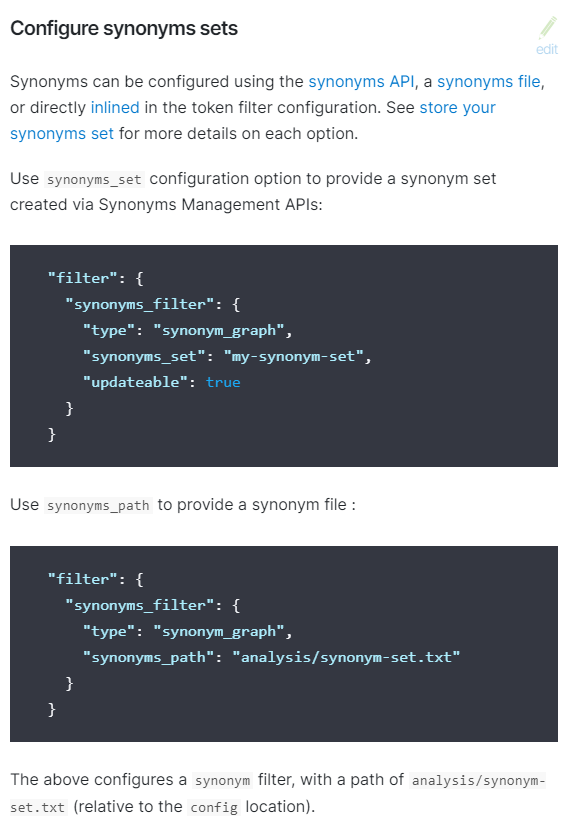

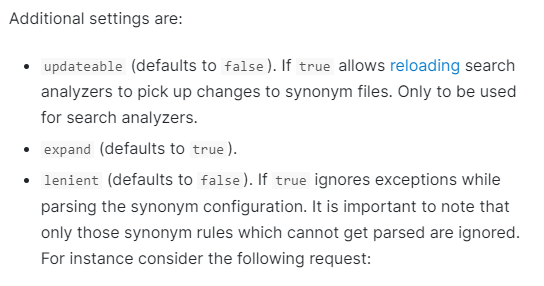

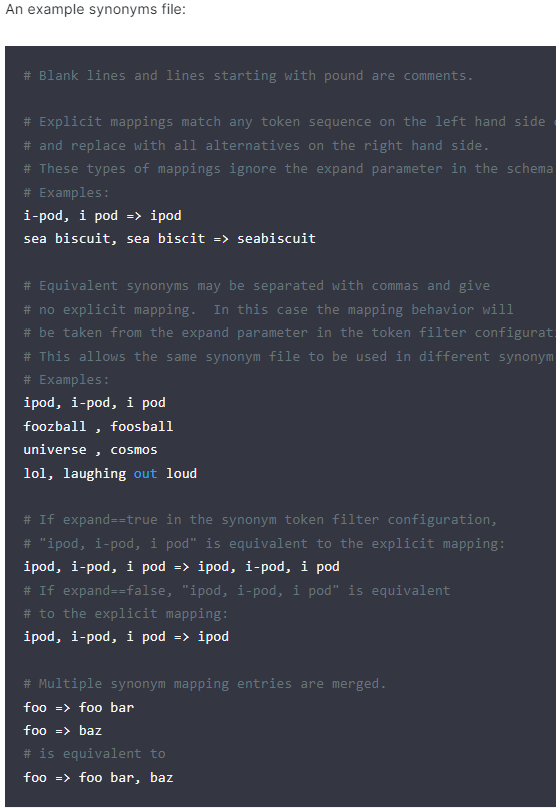